In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Comparing Deep Learning Models for Voice Anti-Spoofing
## This notebook conducts a comparative analysis of different deep learning architectures for classifying a voice as either real or fake (AI-generated).

### We will systematically build, train, and evaluate three distinct models:

Baseline CNN: A simple, shallow Convolutional Neural Network to establish a performance baseline.

Deeper CNN: An enhanced version of the baseline with additional layers to see if increased model capacity improves performance.

Vision Transformer (ViT): A state-of-the-art, pre-trained model adapted for our task through transfer learning.

Each model will be trained and tested independently, with its performance visualized through accuracy/loss curves and a confusion matrix. Finally, we'll compare the results to determine the most effective architecture.

In [3]:
# ==================================================================
# Part 0: Setup, Data Loading, and Visualization
# ==================================================================

# --- Imports and Configuration ---
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchaudio
import torchaudio.transforms as T
import torchvision.models as models
import torchvision.transforms as TV
from torch.amp import GradScaler, autocast # Use the modern torch.amp API

from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# --- Configuration for the LARGE Dataset ---
# !!! IMPORTANT: UPDATE THIS PATH !!!
DATA_DIR = Path("FakeVsRealDataset(for-original)") 

BATCH_SIZE = 16 # REDUCED for larger models. If you get memory errors with ViT, lower this to 8 or 4.
LEARNING_RATE = 0.001
EPOCHS = 15 # INCREASED for the larger dataset. Can be increased further.
TARGET_SAMPLE_RATE = 16000
TARGET_LEN_SECS = 4

# Check for GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device 💻")

Using cuda device 💻


In [4]:
# --- Mel Spectrogram Transform (defined globally) ---
mel_spectrogram_transform = T.MelSpectrogram(
    sample_rate=TARGET_SAMPLE_RATE, n_fft=1024, hop_length=512, n_mels=128
)

# --- AudioDataset Class (Updated to handle errors and mixed file types) ---
class AudioDataset(Dataset):
    def __init__(self, root_path, transform=None, target_sample_rate=TARGET_SAMPLE_RATE, target_len_secs=TARGET_LEN_SECS):
        self.root_path = Path(root_path)
        self.classes = sorted([d.name for d in self.root_path.iterdir() if d.is_dir()])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.transform = transform
        self.target_sample_rate = target_sample_rate
        self.target_len = target_sample_rate * target_len_secs
        # Calculate spectrogram shape once for robust error handling
        self.spec_height = self.transform.n_mels
        self.spec_width = (self.target_len // self.transform.hop_length) + 1
        self.files = self._get_files() # Get files after other attributes are set

    def _get_files(self):
        files = []
        extensions_to_check = ["*.wav", "*.mp3"]
        print(f"Scanning {self.root_path} for {extensions_to_check} and extensionless files...")
        for cls_name in self.classes:
            class_dir = self.root_path / cls_name
            for ext in extensions_to_check:
                files.extend([(p, self.class_to_idx[cls_name]) for p in class_dir.glob(f"**/{ext}")])
            for file_path in class_dir.glob(f"**/*"):
                if file_path.is_file() and not file_path.suffix:
                    files.append((file_path, self.class_to_idx[cls_name]))
        print(f"Found {len(files)} files.")
        return files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"--> WARNING: Skipping corrupted file: {file_path}")
            return torch.zeros(1, self.spec_height, self.spec_width), -1 

        if sample_rate != self.target_sample_rate:
            resampler = T.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
            waveform = resampler(waveform)
            
        if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
        if waveform.shape[1] > self.target_len: waveform = waveform[:, :self.target_len]
        else: waveform = torch.nn.functional.pad(waveform, (0, self.target_len - waveform.shape[1]))
            
        spectrogram = self.transform(waveform)
        return spectrogram, label

## Data Preprocessing Visualization

### Before we build any models, let's understand our data. We will visualize:

1. A raw audio waveform.

2. Its transformation into a Mel Spectrogram, which is the image-like format our models will actually see.

3. The distribution of classes in our training dataset to ensure it's balanced.

Initializing temporary dataset for visualization...
Scanning FakeVsRealDataset(for-original)\training for ['*.wav', '*.mp3'] and extensionless files...
Found 53882 files.


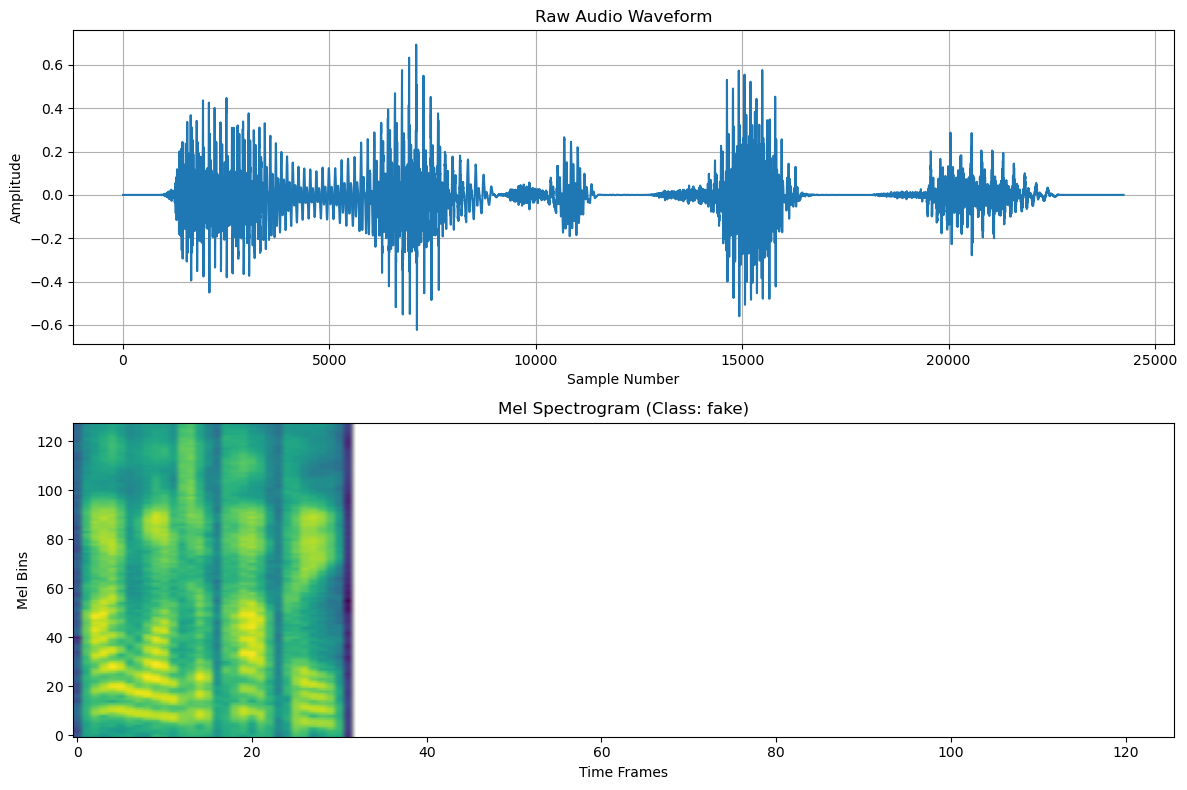

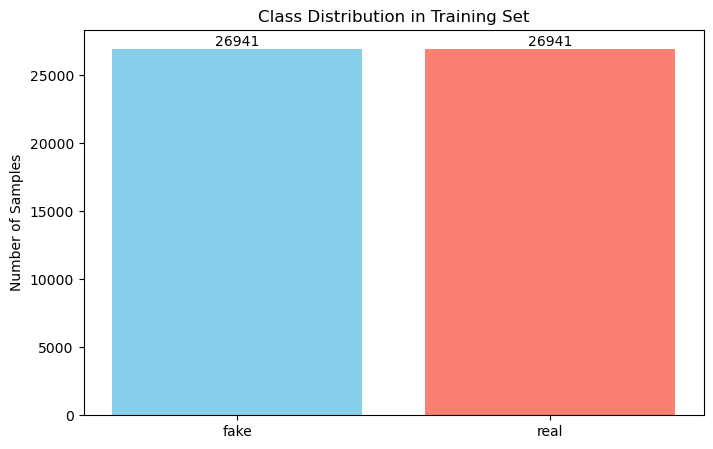

In [5]:
# --- Visualize a sample waveform and its spectrogram ---
print("Initializing temporary dataset for visualization...")
temp_dataset = AudioDataset(root_path=DATA_DIR / "training", transform=mel_spectrogram_transform)

if temp_dataset.files:
    file_info = temp_dataset.files[0]
    waveform, _ = torchaudio.load(file_info[0])
    spectrogram, label_idx = temp_dataset[0]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    ax1.plot(waveform.t().numpy())
    ax1.set_title("Raw Audio Waveform")
    ax1.set_xlabel("Sample Number"); ax1.set_ylabel("Amplitude"); ax1.grid(True)
    
    ax2.imshow(torch.log(spectrogram.squeeze()).numpy(), aspect='auto', origin='lower', cmap='viridis')
    ax2.set_title(f"Mel Spectrogram (Class: {temp_dataset.classes[label_idx]})")
    ax2.set_xlabel("Time Frames"); ax2.set_ylabel("Mel Bins")
    plt.tight_layout()
    plt.show()

    # --- Visualize class distribution ---
    class_counts = {cls: 0 for cls in temp_dataset.classes}
    for _, label_idx in temp_dataset.files:
        class_counts[temp_dataset.classes[label_idx]] += 1
        
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.bar(class_counts.keys(), class_counts.values(), color=['skyblue', 'salmon'])
    ax.set_title('Class Distribution in Training Set')
    ax.set_ylabel('Number of Samples')
    for i, count in enumerate(class_counts.values()):
        ax.text(i, count, str(count), ha='center', va='bottom')
    plt.show()
else:
    print("WARNING: No audio files found for visualization. Please check your DATA_DIR path.")

# Clean up to save memory
del temp_dataset

In [6]:
# --- Create final Datasets and Dataloaders ---
# IMPORTANT: num_workers is set to 0 to prevent freezing issues on Windows in Jupyter
train_dataset = AudioDataset(root_path=DATA_DIR / "training", transform=mel_spectrogram_transform)
val_dataset = AudioDataset(root_path=DATA_DIR / "validation", transform=mel_spectrogram_transform)
test_dataset = AudioDataset(root_path=DATA_DIR / "testing", transform=mel_spectrogram_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"\nDataLoaders created.")

Scanning FakeVsRealDataset(for-original)\training for ['*.wav', '*.mp3'] and extensionless files...
Found 53882 files.
Scanning FakeVsRealDataset(for-original)\validation for ['*.wav', '*.mp3'] and extensionless files...
Found 10800 files.
Scanning FakeVsRealDataset(for-original)\testing for ['*.wav', '*.mp3'] and extensionless files...
Found 4634 files.

DataLoaders created.


In [9]:
# ==================================================================
# Part 1: Reusable Training & Visualization Functions (Corrected)
# ==================================================================

def train_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_acc = 0, 0
    # CORRECTED: GradScaler is initialized without arguments for the new API
    scaler = GradScaler()
    for X, y in tqdm(dataloader, desc="Training"):
        if -1 in y: continue
        X, y = X.to(device), y.to(device)
        
        # CORRECTED: Pass the device string ("cuda" or "cpu") directly
        with autocast(device_type=device):
            y_pred_logits = model(X)
            loss = loss_fn(y_pred_logits, y)
        
        total_loss += loss.item()
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        y_pred_class = torch.argmax(y_pred_logits, dim=1)
        total_acc += (y_pred_class == y).sum().item() / len(y)
    return total_loss / len(dataloader), total_acc / len(dataloader)

def evaluate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for X, y in tqdm(dataloader, desc="Evaluating"):
            if -1 in y: continue
            X, y = X.to(device), y.to(device)
            y_pred_logits = model(X)
            loss = loss_fn(y_pred_logits, y)
            total_loss += loss.item()
            y_pred_class = torch.argmax(y_pred_logits, dim=1)
            total_acc += (y_pred_class == y).sum().item() / len(y)
    return total_loss / len(dataloader), total_acc / len(dataloader)

def run_experiment(model, train_loader, val_loader, loss_fn, optimizer, device, epochs, scheduler=None):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    print(f"\n--- Training {model.__class__.__name__} for {epochs} epochs ---")
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
        print(f"Epoch: {epoch+1:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
        if scheduler:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr < old_lr:
                print(f"    -> Learning rate reduced to {new_lr:.6f}")
    return history

def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    epochs_range = range(1, len(history['train_acc']) + 1)
    ax1.plot(epochs_range, history['train_acc'], label='Train Accuracy', color='blue', marker='o', linestyle='--')
    ax1.plot(epochs_range, history['val_acc'], label='Validation Accuracy', color='orange', marker='o')
    ax1.set_title(f'Model Accuracy'); ax1.set_ylabel('Accuracy'); ax1.set_xlabel('Epoch')
    ax1.legend(loc='lower right'); ax1.grid(True)
    ax2.plot(epochs_range, history['train_loss'], label='Train Loss', color='blue', marker='o', linestyle='--')
    ax2.plot(epochs_range, history['val_loss'], label='Validation Loss', color='orange', marker='o')
    ax2.set_title(f'Model Loss'); ax2.set_ylabel('Loss'); ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper right'); ax2.grid(True)
    fig.suptitle(f'Training History for {title}', fontsize=16); plt.show()
    
def plot_results(model, history, test_loader, loss_fn, device, model_name):
    plot_history(history, model_name)
    print(f"\n--- Final Evaluation on Test Set for {model_name} ---")
    test_loss, test_acc = evaluate(model, test_loader, loss_fn, device)
    print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")
    
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in test_loader:
            if -1 in y: continue
            X, y = X.to(device), y.to(device)
            y_pred_logits = model(X)
            y_pred_class = torch.argmax(y_pred_logits, dim=1)
            all_preds.extend(y_pred_class.cpu().numpy()); all_labels.extend(y.cpu().numpy())
            
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
    fig, ax = plt.subplots(figsize=(6, 6)); disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title(f"Confusion Matrix for {model_name}"); plt.show()
    return test_acc

## Model 1: Baseline CNN

This is our simple, 3-layer CNN. It serves as our starting point to measure all future improvements against.

In [10]:
# --- Define Model ---
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(nn.Linear(15360, 128), nn.ReLU(), nn.Dropout(0.5), nn.Linear(128, num_classes))
    def forward(self, x): return self.linear_stack(self.flatten(self.conv_stack(x)))

# --- Run Experiment ---
model_1_name = "Baseline CNN"
model_1 = BaselineCNN().to(device)
loss_fn_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=LEARNING_RATE)
scheduler_1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_1, mode='min', factor=0.1, patience=2)

baseline_history = run_experiment(model_1, train_loader, val_loader, loss_fn_1, optimizer_1, device, EPOCHS, scheduler_1)


--- Training BaselineCNN for 15 epochs ---


Training:   7%|████▌                                                                | 224/3368 [01:00<13:17,  3.94it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  23%|███████████████▌                                                     | 761/3368 [03:27<11:35,  3.75it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  36%|████████████████████████▌                                           | 1219/3368 [05:38<09:21,  3.83it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  48%|████████████████████████████████▊                                   | 1624/3368 [07:33<08:42,  3.34it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  49%|█████████████████████████████████▋                                  | 1667/3368 [07:47<09:05,  3.12it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  52%|███████████████████████████████████                                 | 1738/3368 [08:07<07:10,  3.78it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  52%|███████████████████████████████████▏                                | 1743/3368 [08:08<07:09,  3.78it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  58%|███████████████████████████████████████▋                            | 1966/3368 [09:11<07:08,  3.27it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  70%|███████████████████████████████████████████████▎                    | 2345/3368 [11:06<04:30,  3.78it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  70%|███████████████████████████████████████████████▉                    | 2374/3368 [11:14<04:11,  3.95it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  72%|█████████████████████████████████████████████████                   | 2428/3368 [11:28<03:40,  4.27it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  86%|██████████████████████████████████████████████████████████▍         | 2894/3368 [13:21<01:42,  4.61it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  98%|██████████████████████████████████████████████████████████████████▋ | 3300/3368 [14:59<00:14,  4.61it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  98%|██████████████████████████████████████████████████████████████████▉ | 3316/3368 [15:04<00:12,  4.20it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:19<01:44,  5.51it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:47<01:13,  5.76it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:13<00:00,  5.07it/s]


Epoch: 01 | Train Loss: nan | Train Acc: 0.9329 | Val Loss: 0.2086 | Val Acc: 0.9194


Training:   7%|█████                                                                | 248/3368 [00:29<05:40,  9.17it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  19%|████████████▊                                                        | 628/3368 [01:16<05:02,  9.06it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  20%|█████████████▊                                                       | 674/3368 [01:21<04:49,  9.30it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  26%|█████████████████▊                                                   | 867/3368 [01:46<06:05,  6.84it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  28%|███████████████████▌                                                 | 954/3368 [02:01<06:07,  6.58it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  31%|█████████████████████                                               | 1044/3368 [02:16<06:36,  5.86it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  34%|███████████████████████▏                                            | 1149/3368 [02:33<06:39,  5.55it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  51%|██████████████████████████████████▋                                 | 1718/3368 [03:57<03:39,  7.52it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  63%|███████████████████████████████████████████                         | 2134/3368 [05:05<02:46,  7.41it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  68%|██████████████████████████████████████████████                      | 2281/3368 [05:31<03:13,  5.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  71%|████████████████████████████████████████████████                    | 2382/3368 [05:54<04:15,  3.86it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  83%|████████████████████████████████████████████████████████▍           | 2798/3368 [07:33<01:56,  4.88it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  87%|███████████████████████████████████████████████████████████▏        | 2933/3368 [08:05<01:30,  4.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  96%|█████████████████████████████████████████████████████████████████▌  | 3249/3368 [09:20<00:24,  4.96it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:19<01:40,  5.72it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:47<01:07,  6.21it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:13<00:00,  5.07it/s]


Epoch: 02 | Train Loss: nan | Train Acc: 0.9606 | Val Loss: 0.1006 | Val Acc: 0.9681


Training:   0%|▏                                                                      | 9/3368 [00:01<05:44,  9.74it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:   3%|██▎                                                                  | 114/3368 [00:11<07:09,  7.58it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:   4%|██▍                                                                  | 121/3368 [00:12<06:21,  8.51it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  13%|█████████                                                            | 443/3368 [00:47<04:22, 11.16it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  52%|███████████████████████████████████▏                                | 1743/3368 [03:22<03:50,  7.06it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  57%|██████████████████████████████████████▊                             | 1920/3368 [03:46<02:45,  8.73it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  58%|███████████████████████████████████████▏                            | 1943/3368 [03:48<02:50,  8.37it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  60%|████████████████████████████████████████▉                           | 2027/3368 [04:00<02:34,  8.68it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  66%|████████████████████████████████████████████▉                       | 2224/3368 [04:28<02:17,  8.30it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  74%|██████████████████████████████████████████████████▋                 | 2509/3368 [05:09<01:58,  7.28it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  79%|█████████████████████████████████████████████████████▊              | 2667/3368 [05:41<02:14,  5.23it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  81%|███████████████████████████████████████████████████████▎            | 2739/3368 [05:57<02:08,  4.88it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  94%|███████████████████████████████████████████████████████████████▉    | 3164/3368 [07:36<00:43,  4.71it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  98%|██████████████████████████████████████████████████████████████████▍ | 3292/3368 [08:06<00:15,  4.79it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:17<01:31,  6.30it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:44<01:06,  6.35it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:07<00:00,  5.30it/s]


Epoch: 03 | Train Loss: nan | Train Acc: 0.9707 | Val Loss: 0.0704 | Val Acc: 0.9796


Training:   4%|██▋                                                                  | 134/3368 [00:13<05:08, 10.47it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:   6%|███▉                                                                 | 194/3368 [00:19<04:38, 11.41it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  10%|███████▏                                                             | 349/3368 [00:34<04:10, 12.03it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  13%|█████████▎                                                           | 454/3368 [00:44<04:20, 11.21it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  17%|███████████▊                                                         | 579/3368 [00:57<04:36, 10.10it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  31%|████████████████████▉                                               | 1037/3368 [01:42<03:40, 10.58it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  46%|███████████████████████████████▌                                    | 1564/3368 [02:35<02:52, 10.45it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  49%|█████████████████████████████████▏                                  | 1646/3368 [02:44<02:50, 10.09it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  54%|████████████████████████████████████▊                               | 1825/3368 [03:03<02:49,  9.09it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  56%|██████████████████████████████████████▏                             | 1892/3368 [03:10<02:20, 10.54it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  61%|█████████████████████████████████████████▍                          | 2050/3368 [03:27<02:21,  9.33it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  63%|███████████████████████████████████████████                         | 2132/3368 [03:36<02:08,  9.60it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  72%|████████████████████████████████████████████████▊                   | 2416/3368 [04:10<01:55,  8.26it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  88%|████████████████████████████████████████████████████████████        | 2974/3368 [05:56<01:19,  4.93it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:17<01:34,  6.09it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:44<01:02,  6.78it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:06<00:00,  5.34it/s]


Epoch: 04 | Train Loss: nan | Train Acc: 0.9759 | Val Loss: 0.0778 | Val Acc: 0.9819


Training:  18%|████████████▌                                                        | 612/3368 [00:58<04:18, 10.67it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  27%|██████████████████▊                                                  | 917/3368 [01:27<03:31, 11.56it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  50%|██████████████████████████████████▏                                 | 1694/3368 [02:46<02:48,  9.91it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  53%|████████████████████████████████████                                | 1785/3368 [02:55<02:41,  9.79it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  77%|████████████████████████████████████████████████████                | 2578/3368 [04:30<01:34,  8.32it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  78%|█████████████████████████████████████████████████████               | 2629/3368 [04:37<01:44,  7.10it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  82%|████████████████████████████████████████████████████████            | 2775/3368 [05:07<01:48,  5.48it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  83%|████████████████████████████████████████████████████████▏           | 2781/3368 [05:08<01:41,  5.80it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  85%|██████████████████████████████████████████████████████████          | 2878/3368 [05:30<01:35,  5.11it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  88%|████████████████████████████████████████████████████████████        | 2973/3368 [05:51<01:25,  4.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  91%|██████████████████████████████████████████████████████████████▏     | 3081/3368 [06:16<00:58,  4.94it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  92%|██████████████████████████████████████████████████████████████▍     | 3090/3368 [06:18<00:59,  4.69it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  95%|████████████████████████████████████████████████████████████████▋   | 3203/3368 [06:45<00:39,  4.14it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  99%|███████████████████████████████████████████████████████████████████ | 3322/3368 [07:13<00:09,  4.74it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:17<01:32,  6.25it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:44<01:05,  6.40it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:03<00:00,  5.47it/s]


Epoch: 05 | Train Loss: nan | Train Acc: 0.9816 | Val Loss: 0.0676 | Val Acc: 0.9832


Training:  31%|█████████████████████▏                                              | 1051/3368 [01:40<03:23, 11.36it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  37%|████████████████████████▉                                           | 1236/3368 [01:58<03:17, 10.80it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  46%|███████████████████████████████▌                                    | 1561/3368 [02:31<02:49, 10.68it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  49%|█████████████████████████████████▏                                  | 1644/3368 [02:39<02:50, 10.10it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  58%|███████████████████████████████████████▋                            | 1965/3368 [03:13<02:20,  9.98it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  64%|███████████████████████████████████████████▌                        | 2158/3368 [03:34<02:02,  9.84it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  64%|███████████████████████████████████████████▊                        | 2169/3368 [03:35<02:07,  9.41it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  67%|█████████████████████████████████████████████▊                      | 2270/3368 [03:46<01:57,  9.31it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  71%|███████████████████████████████████████████████▉                    | 2376/3368 [03:59<01:51,  8.92it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  77%|████████████████████████████████████████████████████▍               | 2599/3368 [04:27<01:32,  8.29it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  88%|████████████████████████████████████████████████████████████▏       | 2978/3368 [05:45<01:19,  4.91it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  90%|█████████████████████████████████████████████████████████████▏      | 3031/3368 [05:57<01:11,  4.71it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  90%|█████████████████████████████████████████████████████████████▍      | 3040/3368 [05:59<01:08,  4.80it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  98%|██████████████████████████████████████████████████████████████████▋ | 3303/3368 [07:01<00:13,  4.67it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:17<01:33,  6.12it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  38%|█████████████████████████▌                                          | 254/675 [00:44<01:12,  5.81it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:02<00:00,  5.52it/s]


Epoch: 06 | Train Loss: nan | Train Acc: 0.9841 | Val Loss: 0.0484 | Val Acc: 0.9901


Training:  16%|██████████▉                                                          | 534/3368 [00:49<04:34, 10.33it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  21%|██████████████▏                                                      | 691/3368 [01:04<04:05, 10.89it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  30%|████████████████████▎                                               | 1005/3368 [01:34<03:34, 11.03it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  33%|██████████████████████▎                                             | 1107/3368 [01:44<03:23, 11.14it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  34%|███████████████████████                                             | 1141/3368 [01:47<03:25, 10.84it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  47%|███████████████████████████████▋                                    | 1568/3368 [02:30<02:47, 10.73it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  47%|███████████████████████████████▊                                    | 1578/3368 [02:31<02:51, 10.42it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  63%|███████████████████████████████████████████                         | 2131/3368 [03:30<02:08,  9.61it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  70%|███████████████████████████████████████████████▌                    | 2353/3368 [03:57<01:47,  9.42it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  75%|██████████████████████████████████████████████████▉                 | 2520/3368 [04:17<01:54,  7.40it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  76%|███████████████████████████████████████████████████▊                | 2564/3368 [04:23<02:19,  5.75it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  85%|█████████████████████████████████████████████████████████▊          | 2863/3368 [05:23<01:45,  4.78it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  87%|███████████████████████████████████████████████████████████         | 2924/3368 [05:37<01:33,  4.73it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  95%|████████████████████████████████████████████████████████████████▋   | 3205/3368 [06:43<00:34,  4.79it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:17<01:32,  6.19it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:43<01:00,  6.98it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:02<00:00,  5.50it/s]


Epoch: 07 | Train Loss: nan | Train Acc: 0.9876 | Val Loss: 0.0277 | Val Acc: 0.9916


Training:   3%|██▎                                                                  | 113/3368 [00:10<04:18, 12.61it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:   4%|██▊                                                                  | 135/3368 [00:12<04:13, 12.75it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:   6%|████▏                                                                | 205/3368 [00:18<04:54, 10.76it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  18%|████████████▋                                                        | 618/3368 [00:57<04:02, 11.33it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  31%|█████████████████████▏                                              | 1048/3368 [01:38<03:48, 10.15it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  33%|██████████████████████▎                                             | 1108/3368 [01:44<03:28, 10.83it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  33%|██████████████████████▋                                             | 1122/3368 [01:45<03:36, 10.37it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  37%|█████████████████████████▏                                          | 1250/3368 [01:57<03:08, 11.25it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  41%|███████████████████████████▊                                        | 1379/3368 [02:10<03:08, 10.53it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  45%|██████████████████████████████▎                                     | 1501/3368 [02:23<02:56, 10.57it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  51%|██████████████████████████████████▎                                 | 1702/3368 [02:44<02:32, 10.90it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  54%|████████████████████████████████████▉                               | 1832/3368 [02:58<02:31, 10.13it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  60%|████████████████████████████████████████▌                           | 2012/3368 [03:18<02:49,  8.00it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  88%|███████████████████████████████████████████████████████████▊        | 2964/3368 [05:43<01:23,  4.81it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:17<01:33,  6.16it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:43<01:06,  6.38it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:05<00:00,  5.36it/s]


Epoch: 08 | Train Loss: nan | Train Acc: 0.9870 | Val Loss: 0.0871 | Val Acc: 0.9910


Training:   3%|██▎                                                                  | 111/3368 [00:10<04:37, 11.73it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  21%|██████████████▎                                                      | 698/3368 [01:05<03:51, 11.53it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  24%|████████████████▍                                                    | 802/3368 [01:16<03:42, 11.55it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  27%|██████████████████▊                                                  | 916/3368 [01:27<03:41, 11.05it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  31%|████████████████████▊                                               | 1032/3368 [01:38<03:29, 11.16it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  41%|███████████████████████████▌                                        | 1365/3368 [02:12<03:37,  9.23it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  46%|███████████████████████████████▍                                    | 1554/3368 [02:32<03:21,  8.99it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  52%|███████████████████████████████████                                 | 1736/3368 [02:52<02:48,  9.71it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  73%|█████████████████████████████████████████████████▋                  | 2461/3368 [04:19<01:56,  7.81it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  80%|██████████████████████████████████████████████████████▋             | 2711/3368 [05:01<02:12,  4.96it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  89%|████████████████████████████████████████████████████████████▋       | 3008/3368 [06:08<01:17,  4.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  91%|█████████████████████████████████████████████████████████████▌      | 3050/3368 [06:18<01:07,  4.68it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  94%|███████████████████████████████████████████████████████████████▉    | 3167/3368 [06:46<00:41,  4.83it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  95%|████████████████████████████████████████████████████████████████▌   | 3198/3368 [06:53<00:35,  4.79it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:17<01:33,  6.13it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:44<01:05,  6.44it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:06<00:00,  5.33it/s]


Epoch: 09 | Train Loss: nan | Train Acc: 0.9884 | Val Loss: 0.0400 | Val Acc: 0.9937


Training:   5%|███                                                                  | 152/3368 [00:14<04:32, 11.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  24%|████████████████▎                                                    | 796/3368 [01:15<03:45, 11.41it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  36%|████████████████████████▍                                           | 1212/3368 [01:55<03:15, 11.05it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  39%|██████████████████████████▊                                         | 1326/3368 [02:06<03:10, 10.71it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  44%|█████████████████████████████▊                                      | 1476/3368 [02:21<03:04, 10.27it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  45%|██████████████████████████████▉                                     | 1530/3368 [02:27<02:49, 10.86it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  46%|███████████████████████████████▌                                    | 1565/3368 [02:30<02:54, 10.34it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3
--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  49%|█████████████████████████████████                                   | 1640/3368 [02:38<02:35, 11.12it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  68%|██████████████████████████████████████████████▎                     | 2291/3368 [03:50<01:46, 10.15it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  69%|███████████████████████████████████████████████                     | 2329/3368 [03:54<01:48,  9.55it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  77%|████████████████████████████████████████████████████▎               | 2590/3368 [04:27<01:33,  8.30it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  82%|███████████████████████████████████████████████████████▍            | 2745/3368 [04:55<01:56,  5.36it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  99%|███████████████████████████████████████████████████████████████████▎| 3334/3368 [07:11<00:07,  4.69it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:18<01:33,  6.13it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:44<01:05,  6.48it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:07<00:00,  5.31it/s]


Epoch: 10 | Train Loss: nan | Train Acc: 0.9895 | Val Loss: 0.0351 | Val Acc: 0.9932
    -> Learning rate reduced to 0.000100


Training:   2%|█▌                                                                    | 75/3368 [00:07<04:55, 11.15it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:   4%|███                                                                  | 148/3368 [00:13<04:34, 11.73it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  18%|████████████▎                                                        | 603/3368 [00:57<03:57, 11.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  19%|████████████▊                                                        | 627/3368 [01:00<04:20, 10.50it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  34%|██████████████████████▊                                             | 1130/3368 [01:50<03:24, 10.97it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  34%|███████████████████████▎                                            | 1156/3368 [01:52<03:21, 11.00it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  36%|████████████████████████▌                                           | 1214/3368 [01:58<03:29, 10.26it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  46%|███████████████████████████████▏                                    | 1543/3368 [02:32<02:52, 10.59it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  61%|█████████████████████████████████████████▋                          | 2065/3368 [03:29<02:13,  9.75it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  63%|██████████████████████████████████████████▊                         | 2123/3368 [03:36<02:09,  9.60it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  64%|███████████████████████████████████████████▎                        | 2146/3368 [03:38<02:15,  9.01it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  68%|██████████████████████████████████████████████▌                     | 2307/3368 [03:58<02:03,  8.59it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  77%|████████████████████████████████████████████████████▎               | 2591/3368 [04:39<02:18,  5.62it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  98%|██████████████████████████████████████████████████████████████████▋ | 3303/3368 [07:21<00:13,  4.71it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:17<01:35,  6.03it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:44<01:06,  6.39it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:07<00:00,  5.31it/s]


Epoch: 11 | Train Loss: nan | Train Acc: 0.9929 | Val Loss: 0.0471 | Val Acc: 0.9955


Training:  13%|█████████                                                            | 443/3368 [00:41<04:11, 11.62it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  21%|██████████████▊                                                      | 721/3368 [01:08<03:59, 11.04it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  25%|█████████████████▍                                                   | 849/3368 [01:21<04:13,  9.93it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  28%|███████████████████▍                                                 | 946/3368 [01:31<03:33, 11.32it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  33%|██████████████████████▎                                             | 1108/3368 [01:47<03:22, 11.17it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  40%|███████████████████████████▎                                        | 1353/3368 [02:11<03:18, 10.13it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  49%|█████████████████████████████████▏                                  | 1644/3368 [02:42<02:40, 10.71it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  55%|█████████████████████████████████████▍                              | 1854/3368 [03:06<02:40,  9.40it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  58%|███████████████████████████████████████▎                            | 1950/3368 [03:17<02:26,  9.69it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  58%|███████████████████████████████████████▋                            | 1967/3368 [03:19<02:16, 10.26it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  71%|████████████████████████████████████████████████▌                   | 2407/3368 [04:14<01:48,  8.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  74%|██████████████████████████████████████████████████▎                 | 2495/3368 [04:26<01:53,  7.70it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  91%|█████████████████████████████████████████████████████████████▊      | 3060/3368 [06:26<01:06,  4.67it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  96%|█████████████████████████████████████████████████████████████████▏  | 3229/3368 [07:05<00:29,  4.79it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:17<01:33,  6.17it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:44<01:04,  6.49it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:06<00:00,  5.34it/s]


Epoch: 12 | Train Loss: nan | Train Acc: 0.9938 | Val Loss: 0.0415 | Val Acc: 0.9956


Training:   2%|█                                                                     | 54/3368 [00:05<04:55, 11.21it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:   9%|██████▎                                                              | 308/3368 [00:28<04:35, 11.11it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  28%|███████████████████▍                                                 | 947/3368 [01:30<03:35, 11.26it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  29%|███████████████████▊                                                 | 966/3368 [01:32<03:53, 10.29it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  38%|█████████████████████████▋                                          | 1275/3368 [02:03<03:15, 10.71it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  41%|████████████████████████████                                        | 1391/3368 [02:14<02:54, 11.35it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  49%|█████████████████████████████████▎                                  | 1652/3368 [02:41<02:32, 11.26it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  56%|██████████████████████████████████████                              | 1885/3368 [03:07<02:32,  9.72it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  61%|█████████████████████████████████████████▎                          | 2046/3368 [03:25<02:26,  9.03it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  71%|████████████████████████████████████████████████▏                   | 2385/3368 [04:06<02:09,  7.60it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  80%|██████████████████████████████████████████████████████▋             | 2709/3368 [04:57<02:09,  5.10it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  85%|█████████████████████████████████████████████████████████▊          | 2862/3368 [05:31<01:30,  5.61it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3
--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  99%|███████████████████████████████████████████████████████████████████▌| 3345/3368 [07:24<00:04,  4.69it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:17<01:36,  5.97it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:44<01:04,  6.50it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:07<00:00,  5.31it/s]


Epoch: 13 | Train Loss: nan | Train Acc: 0.9939 | Val Loss: 0.0481 | Val Acc: 0.9956
    -> Learning rate reduced to 0.000010


Training:   2%|█▎                                                                    | 66/3368 [00:06<04:57, 11.09it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:   7%|████▊                                                                | 234/3368 [00:22<04:41, 11.13it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:   9%|██████                                                               | 294/3368 [00:28<04:21, 11.75it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:   9%|██████▏                                                              | 302/3368 [00:28<04:14, 12.06it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  14%|█████████▎                                                           | 456/3368 [00:43<04:23, 11.04it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  18%|████████████▎                                                        | 601/3368 [00:57<04:24, 10.44it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  29%|███████████████████▊                                                 | 968/3368 [01:33<03:37, 11.03it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  44%|██████████████████████████████                                      | 1488/3368 [02:26<02:55, 10.74it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  50%|█████████████████████████████████▋                                  | 1671/3368 [02:46<02:56,  9.59it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  54%|████████████████████████████████████▌                               | 1810/3368 [03:01<02:36,  9.93it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  68%|██████████████████████████████████████████████▌                     | 2306/3368 [03:59<01:55,  9.23it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  76%|███████████████████████████████████████████████████▌                | 2552/3368 [04:31<01:56,  7.01it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  79%|█████████████████████████████████████████████████████▌              | 2653/3368 [04:47<02:25,  4.91it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  94%|███████████████████████████████████████████████████████████████▉    | 3164/3368 [06:44<00:50,  4.06it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:17<01:35,  6.02it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:44<01:08,  6.13it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:06<00:00,  5.32it/s]


Epoch: 14 | Train Loss: nan | Train Acc: 0.9943 | Val Loss: 0.0488 | Val Acc: 0.9957


Training:  16%|██████████▉                                                          | 532/3368 [00:50<04:35, 10.30it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  28%|███████████████████                                                  | 930/3368 [01:30<03:58, 10.22it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  33%|██████████████████████▍                                             | 1110/3368 [01:48<03:45, 10.01it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  40%|███████████████████████████▎                                        | 1352/3368 [02:12<03:05, 10.88it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  41%|███████████████████████████▋                                        | 1370/3368 [02:14<03:25,  9.70it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  54%|████████████████████████████████████▌                               | 1810/3368 [03:02<02:33, 10.13it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  55%|█████████████████████████████████████▋                              | 1866/3368 [03:09<02:34,  9.70it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  67%|█████████████████████████████████████████████▍                      | 2251/3368 [03:54<02:17,  8.12it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  83%|████████████████████████████████████████████████████████▊           | 2812/3368 [05:31<01:52,  4.96it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  84%|█████████████████████████████████████████████████████████▏          | 2830/3368 [05:35<01:52,  4.80it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  89%|████████████████████████████████████████████████████████████▊       | 3013/3368 [06:21<01:18,  4.53it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  91%|█████████████████████████████████████████████████████████████▌      | 3052/3368 [06:30<01:08,  4.59it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  91%|█████████████████████████████████████████████████████████████▊      | 3060/3368 [06:32<01:08,  4.48it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  95%|████████████████████████████████████████████████████████████████▍   | 3193/3368 [07:04<00:38,  4.59it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:18<01:34,  6.09it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:44<01:06,  6.38it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:08<00:00,  5.27it/s]

Epoch: 15 | Train Loss: nan | Train Acc: 0.9942 | Val Loss: 0.0520 | Val Acc: 0.9956


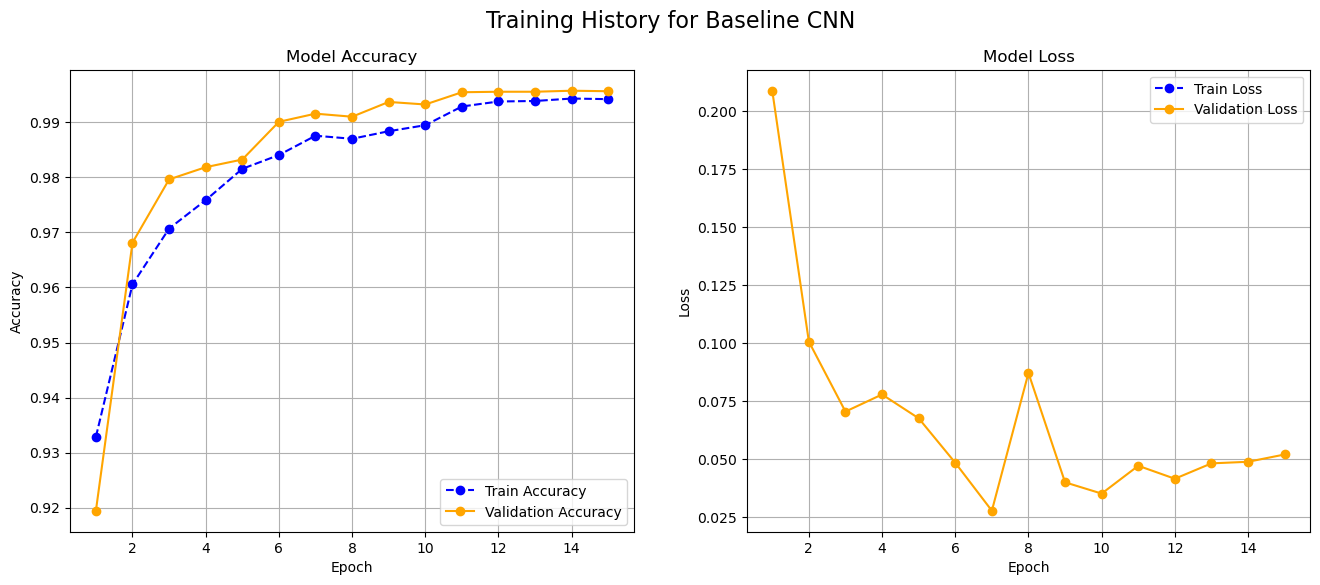


--- Final Evaluation on Test Set for Baseline CNN ---


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 290/290 [00:49<00:00,  5.82it/s]


Test Accuracy: 0.7223 | Test Loss: 10.1445


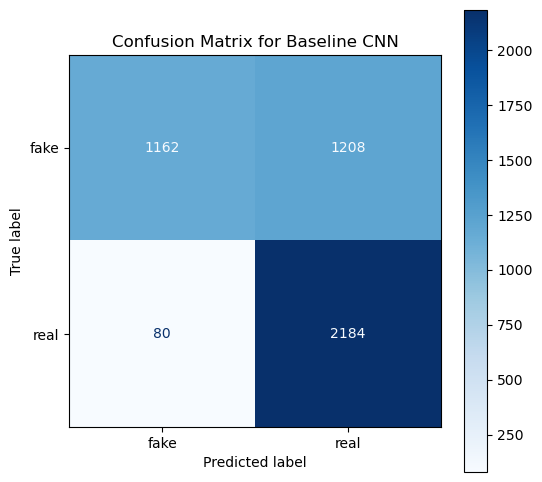

In [11]:
# --- Visualize Results for Model 1 ---
baseline_test_acc = plot_results(model_1, baseline_history, test_loader, loss_fn_1, device, model_1_name)

In [17]:
# --- Save the trained model's weights ---
torch.save(model_1.state_dict(), 'baseline_cnn_model.pth')
print("Baseline CNN model saved to baseline_cnn_model.pth")

Baseline CNN model saved to baseline_cnn_model.pth


## Model 2: Deeper CNN

Let's see if adding more convolutional layers (increasing model depth) allows the network to learn more complex patterns in the spectrograms. We will add an extra Conv2d -> ReLU -> MaxPool2d block.

In [12]:
# --- Define Model ---
class DeeperCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1), nn.ReLU(), nn.BatchNorm2d(16), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1, 1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, 1, 1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.ReLU(), nn.BatchNorm2d(128), nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(128 * 8 * 7, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x): return self.linear_stack(self.flatten(self.conv_stack(x)))

# --- Run Experiment ---
model_2_name = "Deeper CNN"
model_2 = DeeperCNN().to(device)
loss_fn_2 = nn.CrossEntropyLoss()
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=LEARNING_RATE)
scheduler_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, mode='min', factor=0.1, patience=2)

deeper_cnn_history = run_experiment(model_2, train_loader, val_loader, loss_fn_2, optimizer_2, device, EPOCHS, scheduler_2)


--- Training DeeperCNN for 15 epochs ---


Training:   5%|███▊                                                                 | 185/3368 [00:21<05:16, 10.06it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:   6%|████▍                                                                | 217/3368 [00:25<05:21,  9.80it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  13%|████████▊                                                            | 429/3368 [00:50<05:54,  8.29it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  14%|█████████▌                                                           | 466/3368 [00:54<05:29,  8.80it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  29%|███████████████████▋                                                 | 961/3368 [01:54<04:32,  8.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  30%|████████████████████▏                                               | 1000/3368 [01:59<04:27,  8.84it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  57%|███████████████████████████████████████                             | 1935/3368 [04:05<03:37,  6.57it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  62%|██████████████████████████████████████████                          | 2081/3368 [04:28<03:59,  5.38it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  71%|████████████████████████████████████████████████▍                   | 2399/3368 [05:24<03:12,  5.03it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  74%|██████████████████████████████████████████████████▎                 | 2493/3368 [05:46<03:13,  4.52it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  78%|████████████████████████████████████████████████████▊               | 2617/3368 [06:16<02:39,  4.72it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  87%|███████████████████████████████████████████████████████████▏        | 2929/3368 [07:33<01:35,  4.60it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  94%|███████████████████████████████████████████████████████████████▋    | 3153/3368 [08:29<00:48,  4.41it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training: 100%|████████████████████████████████████████████████████████████████████| 3368/3368 [09:23<00:00,  5.98it/s]


--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:18<01:38,  5.81it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:47<01:10,  6.01it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:14<00:00,  5.03it/s]


Epoch: 01 | Train Loss: nan | Train Acc: 0.9474 | Val Loss: nan | Val Acc: 0.4970


Training:   3%|██▍                                                                  | 117/3368 [00:12<04:51, 11.16it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:   5%|███▍                                                                 | 167/3368 [00:17<05:11, 10.26it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:   7%|█████                                                                | 246/3368 [00:25<04:57, 10.50it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:   9%|█████▉                                                               | 288/3368 [00:29<05:00, 10.25it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  16%|██████████▋                                                          | 524/3368 [00:54<04:24, 10.75it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  22%|███████████████▏                                                     | 744/3368 [01:17<04:11, 10.44it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  28%|███████████████████▏                                                 | 936/3368 [01:38<04:09,  9.76it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  42%|████████████████████████████▌                                       | 1412/3368 [02:31<03:35,  9.08it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  42%|████████████████████████████▌                                       | 1416/3368 [02:32<03:23,  9.58it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  66%|█████████████████████████████████████████████                       | 2233/3368 [04:13<02:41,  7.01it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  68%|█████████████████████████████████████████████▉                      | 2276/3368 [04:18<02:03,  8.84it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  82%|███████████████████████████████████████████████████████▊            | 2762/3368 [05:45<02:02,  4.93it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  84%|█████████████████████████████████████████████████████████▍          | 2844/3368 [06:05<01:50,  4.74it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  86%|██████████████████████████████████████████████████████████▎         | 2887/3368 [06:15<01:48,  4.44it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:18<01:38,  5.85it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:46<01:07,  6.22it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:13<00:00,  5.06it/s]


Epoch: 02 | Train Loss: nan | Train Acc: 0.9788 | Val Loss: nan | Val Acc: 0.4970


Training:   3%|██▏                                                                  | 104/3368 [00:10<04:55, 11.05it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  37%|████████████████████████▉                                           | 1237/3368 [02:12<03:58,  8.93it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  41%|████████████████████████████▏                                       | 1397/3368 [02:30<03:30,  9.37it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  43%|█████████████████████████████▌                                      | 1465/3368 [02:38<03:34,  8.88it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  45%|██████████████████████████████▌                                     | 1513/3368 [02:44<03:33,  8.69it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  62%|██████████████████████████████████████████▍                         | 2101/3368 [03:57<02:28,  8.52it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  74%|██████████████████████████████████████████████████▋                 | 2509/3368 [04:56<02:22,  6.01it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  75%|██████████████████████████████████████████████████▋                 | 2513/3368 [04:57<02:29,  5.73it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  77%|████████████████████████████████████████████████████                | 2577/3368 [05:11<02:33,  5.16it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3
--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  79%|█████████████████████████████████████████████████████▋              | 2660/3368 [05:30<02:31,  4.67it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  83%|████████████████████████████████████████████████████████▍           | 2798/3368 [06:03<01:56,  4.91it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  87%|███████████████████████████████████████████████████████████▎        | 2936/3368 [06:37<01:37,  4.45it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  98%|██████████████████████████████████████████████████████████████████▌ | 3295/3368 [08:06<00:16,  4.42it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:18<01:38,  5.81it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:46<01:08,  6.15it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:13<00:00,  5.06it/s]


Epoch: 03 | Train Loss: nan | Train Acc: 0.9842 | Val Loss: nan | Val Acc: 0.4970
    -> Learning rate reduced to 0.000100


Training:   5%|███▎                                                                 | 159/3368 [00:16<05:07, 10.42it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  18%|████████████▋                                                        | 618/3368 [01:04<04:38,  9.87it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  19%|████████████▊                                                        | 628/3368 [01:05<04:23, 10.38it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  26%|█████████████████▋                                                   | 862/3368 [01:31<03:51, 10.84it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  39%|██████████████████████████▊                                         | 1326/3368 [02:21<03:35,  9.49it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  40%|███████████████████████████▏                                        | 1345/3368 [02:23<03:30,  9.61it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  53%|███████████████████████████████████▉                                | 1782/3368 [03:14<02:40,  9.87it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  60%|████████████████████████████████████████▌                           | 2012/3368 [03:43<02:30,  9.03it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  62%|██████████████████████████████████████████▎                         | 2096/3368 [03:53<02:18,  9.16it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  76%|███████████████████████████████████████████████████▌                | 2553/3368 [05:01<02:45,  4.92it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  79%|█████████████████████████████████████████████████████▉              | 2671/3368 [05:28<02:27,  4.71it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  86%|██████████████████████████████████████████████████████████▋         | 2909/3368 [06:26<01:39,  4.61it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  89%|████████████████████████████████████████████████████████████▋       | 3007/3368 [06:50<01:21,  4.44it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  93%|███████████████████████████████████████████████████████████████▎    | 3137/3368 [07:23<00:50,  4.60it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:18<01:34,  6.05it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:46<01:10,  5.95it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:13<00:00,  5.05it/s]


Epoch: 04 | Train Loss: nan | Train Acc: 0.9897 | Val Loss: nan | Val Acc: 0.4970


Training:   4%|██▊                                                                  | 137/3368 [00:14<05:01, 10.71it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  13%|████████▋                                                            | 425/3368 [00:44<04:26, 11.03it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  23%|████████████████                                                     | 784/3368 [01:22<04:35,  9.38it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  30%|████████████████████▍                                                | 999/3368 [01:45<04:28,  8.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  30%|████████████████████▎                                               | 1003/3368 [01:46<04:11,  9.42it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  30%|████████████████████▋                                               | 1027/3368 [01:48<04:33,  8.55it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  45%|██████████████████████████████▋                                     | 1518/3368 [02:44<03:12,  9.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  46%|███████████████████████████████▌                                    | 1564/3368 [02:49<03:20,  8.98it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  55%|█████████████████████████████████████▌                              | 1860/3368 [03:23<02:43,  9.24it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  63%|██████████████████████████████████████████▊                         | 2121/3368 [03:56<02:26,  8.51it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  73%|█████████████████████████████████████████████████▍                  | 2450/3368 [04:41<02:02,  7.51it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  74%|██████████████████████████████████████████████████▌                 | 2504/3368 [04:50<01:56,  7.42it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  82%|███████████████████████████████████████████████████████▉            | 2772/3368 [05:48<02:06,  4.70it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  86%|██████████████████████████████████████████████████████████▏         | 2881/3368 [06:14<01:45,  4.62it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:18<01:38,  5.81it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:46<01:09,  6.05it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:14<00:00,  5.03it/s]


Epoch: 05 | Train Loss: nan | Train Acc: 0.9915 | Val Loss: nan | Val Acc: 0.4970


Training:   5%|███▌                                                                 | 176/3368 [00:18<05:22,  9.89it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  14%|█████████▍                                                           | 460/3368 [00:48<04:40, 10.35it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  20%|█████████████▊                                                       | 677/3368 [01:14<04:31,  9.91it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  22%|███████████████▍                                                     | 751/3368 [01:23<04:18, 10.13it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  25%|█████████████████▏                                                   | 836/3368 [01:33<04:32,  9.31it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  27%|██████████████████▍                                                  | 903/3368 [01:41<04:20,  9.47it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  29%|███████████████████▊                                                 | 968/3368 [01:49<04:23,  9.11it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  40%|██████████████████████████▉                                         | 1335/3368 [02:34<03:28,  9.76it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  43%|█████████████████████████████▎                                      | 1449/3368 [02:48<03:23,  9.43it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  47%|███████████████████████████████▉                                    | 1580/3368 [03:05<04:19,  6.89it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  57%|██████████████████████████████████████▌                             | 1913/3368 [03:50<02:45,  8.77it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  66%|████████████████████████████████████████████▊                       | 2218/3368 [04:34<02:53,  6.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  82%|████████████████████████████████████████████████████████            | 2775/3368 [06:34<02:09,  4.58it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  93%|███████████████████████████████████████████████████████████████▎    | 3136/3368 [08:05<00:50,  4.56it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:19<01:42,  5.60it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:47<01:10,  5.97it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:16<00:00,  4.95it/s]


Epoch: 06 | Train Loss: nan | Train Acc: 0.9916 | Val Loss: nan | Val Acc: 0.4970
    -> Learning rate reduced to 0.000010


Training:  17%|███████████▋                                                         | 573/3368 [01:00<04:24, 10.55it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  25%|█████████████████▍                                                   | 851/3368 [01:30<03:56, 10.65it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  29%|███████████████████▊                                                 | 967/3368 [01:43<03:55, 10.18it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  47%|████████████████████████████████▏                                   | 1593/3368 [02:58<03:54,  7.57it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  50%|█████████████████████████████████▋                                  | 1669/3368 [03:07<03:25,  8.27it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  50%|██████████████████████████████████▎                                 | 1700/3368 [03:11<03:32,  7.85it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  54%|████████████████████████████████████▉                               | 1830/3368 [03:28<03:16,  7.84it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  58%|███████████████████████████████████████▏                            | 1943/3368 [03:43<03:07,  7.62it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  69%|██████████████████████████████████████████████▋                     | 2311/3368 [04:34<02:39,  6.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  69%|██████████████████████████████████████████████▉                     | 2323/3368 [04:35<02:23,  7.26it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  76%|███████████████████████████████████████████████████▍                | 2546/3368 [05:16<02:55,  4.69it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  77%|████████████████████████████████████████████████████                | 2580/3368 [05:23<02:29,  5.27it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  96%|█████████████████████████████████████████████████████████████████▌  | 3245/3368 [08:08<00:26,  4.57it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  99%|███████████████████████████████████████████████████████████████████▍| 3341/3368 [08:32<00:06,  4.35it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:19<01:40,  5.69it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:47<01:11,  5.93it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:15<00:00,  4.98it/s]


Epoch: 07 | Train Loss: nan | Train Acc: 0.9923 | Val Loss: nan | Val Acc: 0.4970


Training:   2%|█▌                                                                    | 74/3368 [00:08<05:28, 10.02it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  25%|█████████████████▍                                                   | 851/3368 [01:31<04:17,  9.79it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  27%|██████████████████▎                                                  | 895/3368 [01:36<03:50, 10.71it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  30%|████████████████████▎                                               | 1004/3368 [01:48<03:53, 10.12it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  40%|███████████████████████████                                         | 1343/3368 [02:27<03:38,  9.29it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  45%|██████████████████████████████▋                                     | 1517/3368 [02:47<03:04, 10.04it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  55%|█████████████████████████████████████▍                              | 1857/3368 [03:29<02:36,  9.64it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  64%|███████████████████████████████████████████▎                        | 2147/3368 [04:07<02:35,  7.86it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  67%|█████████████████████████████████████████████▊                      | 2268/3368 [04:24<02:21,  7.79it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  72%|█████████████████████████████████████████████████                   | 2431/3368 [04:48<02:02,  7.65it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  77%|████████████████████████████████████████████████████                | 2580/3368 [05:19<02:39,  4.95it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  77%|████████████████████████████████████████████████████▎               | 2590/3368 [05:21<02:45,  4.69it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  82%|███████████████████████████████████████████████████████▌            | 2754/3368 [06:01<02:11,  4.65it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  86%|██████████████████████████████████████████████████████████▋         | 2908/3368 [06:39<01:39,  4.62it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:19<01:40,  5.75it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:47<01:09,  6.06it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:15<00:00,  4.97it/s]


Epoch: 08 | Train Loss: nan | Train Acc: 0.9919 | Val Loss: nan | Val Acc: 0.4970


Training:   8%|█████▋                                                               | 275/3368 [00:29<05:46,  8.93it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  14%|█████████▌                                                           | 469/3368 [00:50<04:43, 10.21it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  15%|██████████                                                           | 490/3368 [00:52<04:46, 10.05it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  31%|████████████████████▉                                               | 1036/3368 [01:53<03:56,  9.87it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  39%|██████████████████████████▍                                         | 1308/3368 [02:24<04:01,  8.55it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  48%|████████████████████████████████▍                                   | 1604/3368 [02:59<03:29,  8.41it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  62%|█████████████████████████████████████████▉                          | 2076/3368 [03:59<02:43,  7.90it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  65%|███████████████████████████████████████████▉                        | 2179/3368 [04:15<02:55,  6.77it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  79%|██████████████████████████████████████████████████████              | 2676/3368 [05:44<02:24,  4.78it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  83%|████████████████████████████████████████████████████████▍           | 2794/3368 [06:13<02:04,  4.59it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  83%|████████████████████████████████████████████████████████▌           | 2801/3368 [06:14<02:08,  4.40it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  84%|█████████████████████████████████████████████████████████▏          | 2831/3368 [06:22<02:01,  4.40it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  93%|███████████████████████████████████████████████████████████████▍    | 3140/3368 [07:40<00:51,  4.40it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  95%|████████████████████████████████████████████████████████████████▎   | 3186/3368 [07:51<00:41,  4.38it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:19<01:39,  5.76it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:47<01:11,  5.94it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:16<00:00,  4.96it/s]


Epoch: 09 | Train Loss: nan | Train Acc: 0.9921 | Val Loss: nan | Val Acc: 0.4970
    -> Learning rate reduced to 0.000001


Training:   6%|████                                                                 | 199/3368 [00:21<05:48,  9.10it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  15%|██████████▌                                                          | 516/3368 [00:55<05:15,  9.05it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  16%|██████████▉                                                          | 534/3368 [00:57<04:31, 10.42it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  17%|███████████▍                                                         | 559/3368 [01:00<04:58,  9.40it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  28%|███████████████████▎                                                 | 943/3368 [01:43<04:11,  9.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  31%|████████████████████▊                                               | 1029/3368 [01:53<04:13,  9.22it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  33%|██████████████████████▍                                             | 1113/3368 [02:02<03:59,  9.42it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  37%|████████████████████████▉                                           | 1234/3368 [02:16<03:48,  9.35it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  49%|█████████████████████████████████▌                                  | 1661/3368 [03:08<02:55,  9.70it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  60%|█████████████████████████████████████████                           | 2032/3368 [03:56<02:26,  9.15it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  67%|█████████████████████████████████████████████▋                      | 2263/3368 [04:29<02:07,  8.67it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  72%|████████████████████████████████████████████████▋                   | 2413/3368 [04:52<02:17,  6.92it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  83%|████████████████████████████████████████████████████████▍           | 2797/3368 [06:19<02:06,  4.52it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  94%|███████████████████████████████████████████████████████████████▋    | 3157/3368 [07:50<00:46,  4.58it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:19<01:42,  5.60it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:49<01:14,  5.70it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:18<00:00,  4.87it/s]


Epoch: 10 | Train Loss: nan | Train Acc: 0.9926 | Val Loss: nan | Val Acc: 0.4970


Training:   3%|██▏                                                                  | 107/3368 [00:12<05:41,  9.56it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  28%|███████████████████▎                                                 | 945/3368 [01:47<05:33,  7.26it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  32%|█████████████████████▊                                              | 1081/3368 [02:03<04:31,  8.43it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  33%|██████████████████████▏                                             | 1096/3368 [02:05<04:09,  9.09it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  34%|███████████████████████▍                                            | 1160/3368 [02:13<04:04,  9.03it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  38%|█████████████████████████▉                                          | 1286/3368 [02:29<04:52,  7.11it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  48%|████████████████████████████████▊                                   | 1626/3368 [03:13<03:58,  7.30it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  54%|████████████████████████████████████▍                               | 1805/3368 [03:38<03:51,  6.74it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  54%|████████████████████████████████████▌                               | 1810/3368 [03:38<03:23,  7.66it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  55%|█████████████████████████████████████▎                              | 1850/3368 [03:44<04:14,  5.97it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  60%|█████████████████████████████████████████                           | 2035/3368 [04:11<03:11,  6.97it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  74%|██████████████████████████████████████████████████▋                 | 2508/3368 [05:40<02:54,  4.93it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  86%|██████████████████████████████████████████████████████████▎         | 2889/3368 [07:14<01:47,  4.45it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  93%|███████████████████████████████████████████████████████████████▍    | 3141/3368 [08:39<00:53,  4.22it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:19<01:48,  5.30it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:50<01:15,  5.58it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:25<00:00,  4.64it/s]


Epoch: 11 | Train Loss: nan | Train Acc: 0.9922 | Val Loss: nan | Val Acc: 0.4970


Training:   3%|█▉                                                                    | 91/3368 [00:12<08:21,  6.54it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  21%|██████████████▋                                                      | 716/3368 [01:35<05:06,  8.64it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  28%|███████████████████▍                                                 | 949/3368 [02:09<06:30,  6.19it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  29%|███████████████████▋                                                 | 963/3368 [02:11<05:45,  6.97it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  32%|█████████████████████▉                                              | 1088/3368 [02:30<04:55,  7.71it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  36%|████████████████████████▏                                           | 1196/3368 [02:48<05:19,  6.79it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  41%|███████████████████████████▊                                        | 1377/3368 [03:16<04:24,  7.54it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  47%|███████████████████████████████▋                                    | 1569/3368 [03:48<04:03,  7.38it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  48%|████████████████████████████████▋                                   | 1622/3368 [03:57<04:23,  6.62it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  49%|█████████████████████████████████                                   | 1636/3368 [04:00<05:02,  5.73it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  68%|██████████████████████████████████████████████▍                     | 2297/3368 [06:18<03:44,  4.77it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  86%|██████████████████████████████████████████████████████████▋         | 2908/3368 [08:40<01:40,  4.58it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  88%|███████████████████████████████████████████████████████████▋        | 2957/3368 [08:52<01:33,  4.40it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  93%|███████████████████████████████████████████████████████████████▌    | 3148/3368 [09:39<01:19,  2.78it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:20<01:43,  5.56it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:50<01:23,  5.03it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:25<00:00,  4.63it/s]


Epoch: 12 | Train Loss: nan | Train Acc: 0.9925 | Val Loss: nan | Val Acc: 0.4970
    -> Learning rate reduced to 0.000000


Training:   2%|█▌                                                                    | 73/3368 [00:09<06:21,  8.64it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:   3%|█▊                                                                    | 87/3368 [00:11<07:08,  7.65it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:   8%|█████▊                                                               | 285/3368 [00:37<06:03,  8.49it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:   9%|██████▍                                                              | 315/3368 [00:40<06:20,  8.03it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  14%|█████████▊                                                           | 481/3368 [01:02<05:56,  8.10it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  21%|██████████████▌                                                      | 711/3368 [01:34<06:04,  7.29it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  42%|████████████████████████████▊                                       | 1430/3368 [03:19<04:52,  6.61it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  64%|███████████████████████████████████████████▋                        | 2163/3368 [05:20<03:52,  5.18it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  67%|█████████████████████████████████████████████▏                      | 2241/3368 [05:35<03:01,  6.22it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  75%|██████████████████████████████████████████████████▋                 | 2510/3368 [06:38<02:53,  4.94it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  79%|█████████████████████████████████████████████████████▍              | 2648/3368 [07:10<02:30,  4.78it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  80%|██████████████████████████████████████████████████████▎             | 2690/3368 [07:20<02:35,  4.35it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  83%|████████████████████████████████████████████████████████▋           | 2809/3368 [07:49<02:05,  4.44it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  99%|███████████████████████████████████████████████████████████████████▎| 3331/3368 [10:03<00:08,  4.51it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:19<01:40,  5.70it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:48<01:24,  4.99it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:17<00:00,  4.91it/s]


Epoch: 13 | Train Loss: nan | Train Acc: 0.9919 | Val Loss: nan | Val Acc: 0.4970


Training:  10%|███████▏                                                             | 349/3368 [00:43<06:35,  7.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  15%|██████████                                                           | 489/3368 [01:00<05:18,  9.05it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  29%|████████████████████                                                 | 980/3368 [02:05<05:09,  7.71it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  29%|████████████████████▎                                                | 989/3368 [02:06<04:47,  8.29it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  36%|████████████████████████▎                                           | 1203/3368 [02:36<04:51,  7.44it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  38%|█████████████████████████▉                                          | 1282/3368 [02:48<04:25,  7.86it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  50%|█████████████████████████████████▊                                  | 1677/3368 [03:48<04:02,  6.98it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  51%|███████████████████████████████████                                 | 1734/3368 [03:57<03:55,  6.94it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  52%|███████████████████████████████████▎                                | 1751/3368 [04:00<04:36,  5.85it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  56%|██████████████████████████████████████▎                             | 1898/3368 [04:25<03:07,  7.85it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  59%|████████████████████████████████████████▎                           | 1999/3368 [04:44<04:10,  5.46it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  83%|████████████████████████████████████████████████████████▋           | 2806/3368 [07:46<02:07,  4.40it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  85%|█████████████████████████████████████████████████████████▌          | 2854/3368 [07:58<01:51,  4.62it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  85%|██████████████████████████████████████████████████████████          | 2875/3368 [08:04<01:49,  4.50it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:19<01:46,  5.39it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:48<01:14,  5.68it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:17<00:00,  4.91it/s]


Epoch: 14 | Train Loss: nan | Train Acc: 0.9923 | Val Loss: nan | Val Acc: 0.4970


Training:   3%|█▉                                                                    | 92/3368 [00:10<05:54,  9.23it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  19%|█████████████▏                                                       | 646/3368 [01:12<04:54,  9.23it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  22%|███████████████▍                                                     | 751/3368 [01:24<04:30,  9.69it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  42%|████████████████████████████▎                                       | 1402/3368 [02:45<03:55,  8.34it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  43%|█████████████████████████████                                       | 1439/3368 [02:49<03:31,  9.11it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  48%|████████████████████████████████▉                                   | 1631/3368 [03:14<03:34,  8.08it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  55%|█████████████████████████████████████▎                              | 1850/3368 [03:44<03:08,  8.05it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  58%|███████████████████████████████████████▏                            | 1939/3368 [03:57<03:12,  7.41it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  67%|█████████████████████████████████████████████▌                      | 2257/3368 [04:47<02:26,  7.58it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  84%|█████████████████████████████████████████████████████████▏          | 2834/3368 [06:59<02:03,  4.32it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  87%|███████████████████████████████████████████████████████████         | 2928/3368 [07:23<01:35,  4.62it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  96%|█████████████████████████████████████████████████████████████████▏  | 3229/3368 [08:39<00:30,  4.56it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  97%|██████████████████████████████████████████████████████████████████▏ | 3276/3368 [08:51<00:20,  4.40it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training: 100%|███████████████████████████████████████████████████████████████████▊| 3361/3368 [09:12<00:01,  4.30it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:19<01:39,  5.79it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [00:48<01:13,  5.72it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [02:16<00:00,  4.95it/s]

Epoch: 15 | Train Loss: nan | Train Acc: 0.9921 | Val Loss: nan | Val Acc: 0.4970
    -> Learning rate reduced to 0.000000


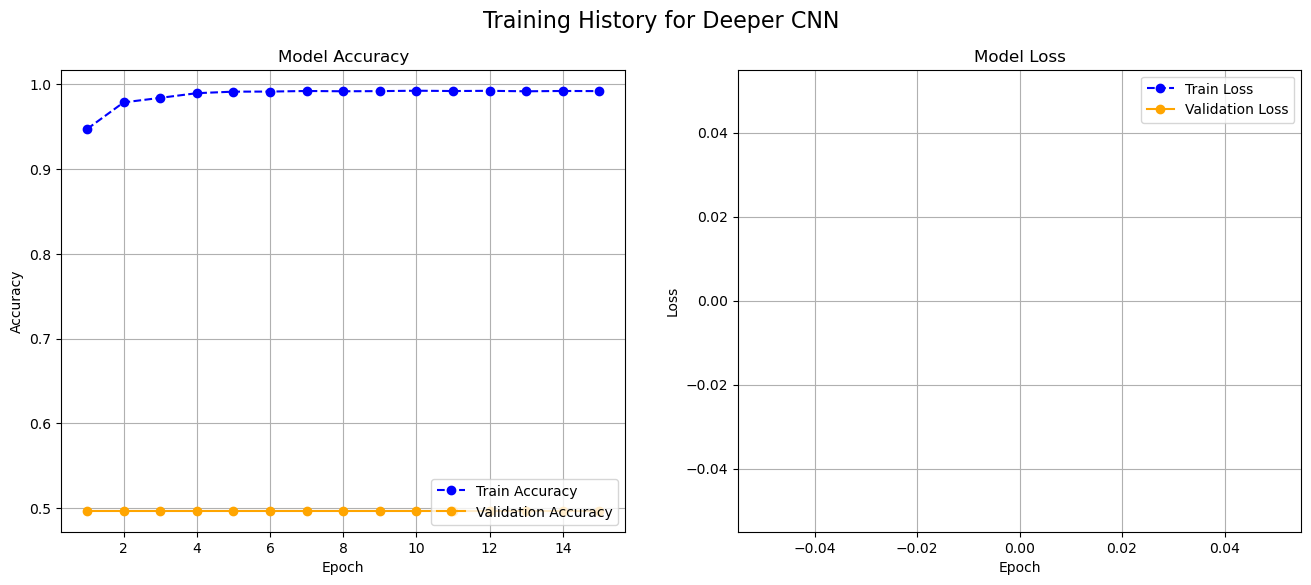


--- Final Evaluation on Test Set for Deeper CNN ---


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 290/290 [00:53<00:00,  5.43it/s]


Test Accuracy: 0.5108 | Test Loss: nan


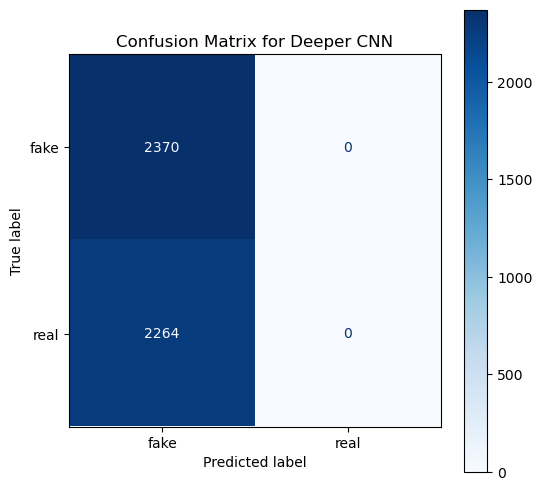

In [13]:
# --- Visualize Results for Model 2 ---
deeper_cnn_test_acc = plot_results(model_2, deeper_cnn_history, test_loader, loss_fn_2, device, model_2_name)

In [18]:
# --- Save the trained model's weights ---
torch.save(model_2.state_dict(), 'deeper_cnn_model.pth')
print("Deeper CNN model saved to deeper_cnn_model.pth")

Deeper CNN model saved to deeper_cnn_model.pth


## Model 3: Vision Transformer (Transfer Learning)

Now for a completely different approach. We will use a Vision Transformer (ViT), a powerful architecture pre-trained on millions of images. We will adapt it for our task by:

1. Modifying its input "patch embedding" layer to handle our 1-channel spectrograms.

2. Replacing its final classifier with one suited for our 2 classes.

### This demonstrates the power of transfer learning.

In [14]:
# --- Define Model ---
class ViTModel(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        original_conv = self.vit.conv_proj
        self.vit.conv_proj = nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
        self.vit.conv_proj.weight.data = original_conv.weight.data.mean(dim=1, keepdim=True)
        self.resizer = TV.Resize((224, 224), antialias=True)
        self.vit.heads.head = nn.Linear(self.vit.heads.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(self.resizer(x))

# --- Run Experiment ---
model_3_name = "Vision Transformer (ViT)"
model_3 = ViTModel().to(device)
loss_fn_3 = nn.CrossEntropyLoss()
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=LEARNING_RATE / 10) 
scheduler_3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_3, mode='min', factor=0.1, patience=2)

vit_history = run_experiment(model_3, train_loader, val_loader, loss_fn_3, optimizer_3, device, EPOCHS, scheduler_3)


--- Training ViTModel for 15 epochs ---


Training:   8%|█████▌                                                               | 269/3368 [01:32<14:15,  3.62it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  21%|██████████████▌                                                      | 710/3368 [04:08<12:53,  3.44it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  24%|████████████████▊                                                    | 822/3368 [04:48<12:29,  3.39it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  36%|████████████████████████▏                                           | 1199/3368 [07:06<11:11,  3.23it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  37%|█████████████████████████▏                                          | 1249/3368 [07:25<12:50,  2.75it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  37%|█████████████████████████▍                                          | 1257/3368 [07:27<10:08,  3.47it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  50%|██████████████████████████████████▏                                 | 1693/3368 [10:14<08:59,  3.11it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  60%|████████████████████████████████████████▉                           | 2028/3368 [12:32<07:41,  2.91it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  71%|████████████████████████████████████████████████▍                   | 2401/3368 [15:08<05:35,  2.88it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  79%|█████████████████████████████████████████████████████▊              | 2666/3368 [16:59<04:04,  2.87it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  81%|██████████████████████████████████████████████████████▉             | 2719/3368 [17:21<03:44,  2.89it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  84%|█████████████████████████████████████████████████████████           | 2828/3368 [18:06<03:08,  2.86it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  85%|█████████████████████████████████████████████████████████▉          | 2870/3368 [18:24<02:53,  2.87it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  96%|█████████████████████████████████████████████████████████████████▎  | 3234/3368 [20:56<00:46,  2.89it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:33<02:42,  3.54it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:23<01:56,  3.62it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [03:51<00:00,  2.92it/s]


Epoch: 01 | Train Loss: nan | Train Acc: 0.9384 | Val Loss: 0.0502 | Val Acc: 0.9794


Training:   3%|██                                                                   | 103/3368 [00:35<18:38,  2.92it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:   8%|█████▌                                                               | 269/3368 [01:31<17:52,  2.89it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:   8%|█████▋                                                               | 277/3368 [01:34<17:32,  2.94it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:   9%|██████▌                                                              | 318/3368 [01:48<17:16,  2.94it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  20%|█████████████▉                                                       | 680/3368 [03:52<12:12,  3.67it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  26%|█████████████████▋                                                   | 863/3368 [04:56<11:34,  3.61it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  54%|████████████████████████████████████▋                               | 1816/3368 [10:38<07:45,  3.34it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  71%|████████████████████████████████████████████████                    | 2381/3368 [14:22<05:40,  2.89it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  74%|██████████████████████████████████████████████████▎                 | 2490/3368 [15:07<05:02,  2.90it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  78%|████████████████████████████████████████████████████▊               | 2613/3368 [15:59<04:25,  2.85it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  83%|████████████████████████████████████████████████████████▏           | 2785/3368 [17:11<03:22,  2.88it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  91%|█████████████████████████████████████████████████████████████▉      | 3070/3368 [19:10<01:43,  2.87it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  96%|█████████████████████████████████████████████████████████████████▏  | 3227/3368 [20:16<00:47,  2.95it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training: 100%|███████████████████████████████████████████████████████████████████▉| 3367/3368 [21:15<00:00,  2.87it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:33<02:38,  3.62it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:23<01:53,  3.73it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [03:50<00:00,  2.93it/s]


Epoch: 02 | Train Loss: nan | Train Acc: 0.9787 | Val Loss: 0.0386 | Val Acc: 0.9839


Training:   4%|██▉                                                                  | 143/3368 [00:48<18:01,  2.98it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  23%|███████████████▌                                                     | 761/3368 [04:23<15:27,  2.81it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  30%|████████████████████▍                                               | 1014/3368 [05:51<11:08,  3.52it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  39%|██████████████████████████▋                                         | 1320/3368 [07:41<10:00,  3.41it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  39%|██████████████████████████▋                                         | 1324/3368 [07:42<09:29,  3.59it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  42%|████████████████████████████▋                                       | 1420/3368 [08:17<11:39,  2.78it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  42%|████████████████████████████▊                                       | 1430/3368 [08:20<09:39,  3.34it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  57%|███████████████████████████████████████                             | 1932/3368 [11:26<09:03,  2.64it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  63%|██████████████████████████████████████████▊                         | 2119/3368 [12:38<06:59,  2.98it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  79%|█████████████████████████████████████████████████████▊              | 2668/3368 [16:27<04:07,  2.83it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  84%|████████████████████████████████████████████████████████▊           | 2814/3368 [17:28<03:09,  2.93it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  88%|████████████████████████████████████████████████████████████        | 2973/3368 [18:35<02:17,  2.88it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  95%|████████████████████████████████████████████████████████████████▌   | 3195/3368 [20:09<00:59,  2.90it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  97%|██████████████████████████████████████████████████████████████████  | 3272/3368 [20:41<00:32,  2.95it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:33<02:39,  3.61it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:23<01:54,  3.68it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [03:51<00:00,  2.91it/s]


Epoch: 03 | Train Loss: nan | Train Acc: 0.9850 | Val Loss: 0.0475 | Val Acc: 0.9822


Training:   5%|███▎                                                                 | 161/3368 [00:55<14:43,  3.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:   7%|█████▏                                                               | 252/3368 [01:27<18:02,  2.88it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  13%|█████████                                                            | 444/3368 [02:33<16:44,  2.91it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  16%|██████████▊                                                          | 527/3368 [03:02<13:03,  3.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  20%|█████████████▊                                                       | 675/3368 [03:54<15:54,  2.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  24%|████████████████▊                                                    | 823/3368 [04:46<12:08,  3.50it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  46%|███████████████████████████████▌                                    | 1562/3368 [09:13<10:48,  2.78it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  62%|█████████████████████████████████████████▊                          | 2072/3368 [12:26<07:04,  3.05it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  65%|███████████████████████████████████████████▊                        | 2173/3368 [13:07<06:36,  3.02it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  75%|██████████████████████████████████████████████████▋                 | 2512/3368 [15:30<05:03,  2.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  80%|██████████████████████████████████████████████████████▋             | 2708/3368 [16:53<03:48,  2.89it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  82%|███████████████████████████████████████████████████████▌            | 2749/3368 [17:10<03:30,  2.93it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  83%|████████████████████████████████████████████████████████▏           | 2786/3368 [17:25<03:27,  2.81it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  84%|████████████████████████████████████████████████████████▉           | 2821/3368 [17:40<03:08,  2.91it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:33<02:40,  3.57it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:24<01:54,  3.68it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [03:53<00:00,  2.89it/s]


Epoch: 04 | Train Loss: nan | Train Acc: 0.9878 | Val Loss: 0.0175 | Val Acc: 0.9910


Training:  23%|███████████████▋                                                     | 763/3368 [04:27<12:18,  3.53it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  29%|███████████████████▉                                                 | 976/3368 [05:44<11:19,  3.52it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  36%|████████████████████████▋                                           | 1225/3368 [07:13<10:17,  3.47it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  40%|███████████████████████████▎                                        | 1350/3368 [07:59<12:26,  2.70it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  41%|███████████████████████████▊                                        | 1379/3368 [08:10<09:57,  3.33it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  44%|██████████████████████████████▏                                     | 1494/3368 [08:52<09:04,  3.44it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  51%|██████████████████████████████████▋                                 | 1717/3368 [10:15<10:16,  2.68it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  56%|██████████████████████████████████████                              | 1888/3368 [11:20<07:51,  3.14it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  63%|██████████████████████████████████████████▌                         | 2107/3368 [12:48<07:11,  2.92it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  83%|████████████████████████████████████████████████████████▏           | 2783/3368 [17:34<03:18,  2.95it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  85%|█████████████████████████████████████████████████████████▊          | 2861/3368 [18:07<02:59,  2.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  89%|████████████████████████████████████████████████████████████▊       | 3009/3368 [19:09<02:06,  2.83it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  91%|█████████████████████████████████████████████████████████████▋      | 3058/3368 [19:29<01:45,  2.94it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  99%|███████████████████████████████████████████████████████████████████ | 3323/3368 [21:22<00:15,  2.88it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:33<02:43,  3.52it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:24<01:58,  3.55it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [03:54<00:00,  2.88it/s]


Epoch: 05 | Train Loss: nan | Train Acc: 0.9895 | Val Loss: 0.0230 | Val Acc: 0.9906


Training:   2%|█▏                                                                    | 57/3368 [00:19<15:11,  3.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  18%|████████████▊                                                        | 623/3368 [03:38<16:11,  2.83it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  21%|██████████████▎                                                      | 699/3368 [04:04<15:49,  2.81it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  25%|█████████████████▎                                                   | 845/3368 [04:56<11:39,  3.61it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  30%|████████████████████▏                                               | 1002/3368 [05:52<14:05,  2.80it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  42%|████████████████████████████▍                                       | 1408/3368 [08:20<09:50,  3.32it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  52%|███████████████████████████████████                                 | 1738/3368 [10:23<08:20,  3.26it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  52%|███████████████████████████████████▎                                | 1752/3368 [10:28<08:19,  3.24it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  56%|██████████████████████████████████████▎                             | 1899/3368 [11:24<07:37,  3.21it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  60%|████████████████████████████████████████▌                           | 2011/3368 [12:08<07:15,  3.12it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  74%|██████████████████████████████████████████████████▌                 | 2507/3368 [15:36<04:57,  2.90it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  78%|█████████████████████████████████████████████████████               | 2628/3368 [16:27<04:25,  2.78it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  80%|██████████████████████████████████████████████████████▏             | 2683/3368 [16:50<03:58,  2.88it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  97%|██████████████████████████████████████████████████████████████████  | 3273/3368 [21:02<00:33,  2.81it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:33<02:46,  3.46it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:24<01:55,  3.65it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [03:54<00:00,  2.87it/s]


Epoch: 06 | Train Loss: nan | Train Acc: 0.9912 | Val Loss: 0.0140 | Val Acc: 0.9917


Training:   0%|▏                                                                     | 12/3368 [00:03<15:53,  3.52it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:   8%|█████▊                                                               | 284/3368 [01:39<18:17,  2.81it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  24%|████████████████▋                                                    | 815/3368 [04:47<14:36,  2.91it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  34%|██████████████████████▉                                             | 1137/3368 [06:42<13:46,  2.70it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  39%|██████████████████████████▊                                         | 1325/3368 [07:50<12:37,  2.70it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  58%|███████████████████████████████████████▊                            | 1970/3368 [11:50<07:11,  3.24it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  68%|██████████████████████████████████████████████▏                     | 2288/3368 [14:01<06:04,  2.96it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  73%|█████████████████████████████████████████████████▌                  | 2452/3368 [15:10<05:15,  2.90it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  74%|██████████████████████████████████████████████████▏                 | 2483/3368 [15:24<05:16,  2.80it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  75%|██████████████████████████████████████████████████▉                 | 2520/3368 [15:39<04:50,  2.92it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  79%|█████████████████████████████████████████████████████▉              | 2672/3368 [16:44<04:03,  2.86it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  87%|███████████████████████████████████████████████████████████▎        | 2939/3368 [18:37<02:32,  2.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  97%|██████████████████████████████████████████████████████████████████▏ | 3277/3368 [21:01<00:31,  2.85it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  99%|███████████████████████████████████████████████████████████████████▍| 3343/3368 [21:29<00:08,  2.97it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:33<02:43,  3.52it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:25<01:55,  3.64it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [03:55<00:00,  2.87it/s]


Epoch: 07 | Train Loss: nan | Train Acc: 0.9916 | Val Loss: 0.0196 | Val Acc: 0.9901


Training:   2%|█                                                                     | 52/3368 [00:18<19:06,  2.89it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:   6%|████▍                                                                | 217/3368 [01:15<18:03,  2.91it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:   8%|█████▊                                                               | 284/3368 [01:38<14:20,  3.58it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:   9%|██████▏                                                              | 299/3368 [01:43<17:55,  2.85it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  10%|██████▊                                                              | 332/3368 [01:54<14:12,  3.56it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  13%|█████████▏                                                           | 449/3368 [02:35<17:15,  2.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  28%|███████████████████                                                  | 928/3368 [05:25<11:25,  3.56it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  37%|█████████████████████████▎                                          | 1251/3368 [07:22<10:26,  3.38it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  65%|████████████████████████████████████████████▌                       | 2205/3368 [13:27<06:34,  2.95it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  79%|█████████████████████████████████████████████████████▍              | 2648/3368 [16:35<04:08,  2.89it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  84%|█████████████████████████████████████████████████████████▍          | 2842/3368 [17:57<03:07,  2.80it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  89%|████████████████████████████████████████████████████████████▌       | 2997/3368 [19:03<02:09,  2.87it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  97%|██████████████████████████████████████████████████████████████████▎ | 3282/3368 [21:04<00:29,  2.88it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  98%|██████████████████████████████████████████████████████████████████▌ | 3295/3368 [21:09<00:26,  2.78it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:33<02:44,  3.49it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:25<01:59,  3.55it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [03:56<00:00,  2.86it/s]


Epoch: 08 | Train Loss: nan | Train Acc: 0.9922 | Val Loss: 0.0089 | Val Acc: 0.9941


Training:   7%|████▊                                                                | 237/3368 [01:23<18:07,  2.88it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:   7%|█████▏                                                               | 252/3368 [01:28<18:10,  2.86it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  10%|███████▏                                                             | 350/3368 [02:02<17:34,  2.86it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  12%|████████▍                                                            | 410/3368 [02:23<17:18,  2.85it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  17%|███████████▉                                                         | 580/3368 [03:23<16:33,  2.81it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  21%|██████████████▊                                                      | 721/3368 [04:13<12:35,  3.51it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  35%|███████████████████████▋                                            | 1172/3368 [06:57<10:44,  3.41it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  38%|█████████████████████████▌                                          | 1269/3368 [07:33<10:31,  3.33it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  39%|██████████████████████████▋                                         | 1324/3368 [07:54<13:11,  2.58it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  49%|█████████████████████████████████▎                                  | 1647/3368 [09:54<08:28,  3.38it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  63%|██████████████████████████████████████████▌                         | 2106/3368 [12:53<07:08,  2.95it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  65%|████████████████████████████████████████████▍                       | 2199/3368 [13:31<06:48,  2.86it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  76%|███████████████████████████████████████████████████▍                | 2547/3368 [15:59<04:46,  2.87it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  97%|█████████████████████████████████████████████████████████████████▋  | 3254/3368 [21:00<00:39,  2.86it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:33<02:39,  3.60it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:25<01:57,  3.59it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [03:56<00:00,  2.85it/s]


Epoch: 09 | Train Loss: nan | Train Acc: 0.9924 | Val Loss: 0.0075 | Val Acc: 0.9940


Training:  14%|█████████▋                                                           | 472/3368 [02:46<13:33,  3.56it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  34%|███████████████████████                                             | 1140/3368 [06:46<10:47,  3.44it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  35%|███████████████████████▋                                            | 1172/3368 [06:57<13:17,  2.75it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  35%|███████████████████████▊                                            | 1181/3368 [07:00<10:06,  3.61it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  36%|████████████████████████▊                                           | 1228/3368 [07:17<13:07,  2.72it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  40%|███████████████████████████▌                                        | 1363/3368 [08:06<09:56,  3.36it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  41%|███████████████████████████▉                                        | 1383/3368 [08:13<11:18,  2.93it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  55%|█████████████████████████████████████▍                              | 1854/3368 [11:09<08:00,  3.15it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  57%|███████████████████████████████████████                             | 1932/3368 [11:38<07:10,  3.34it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  60%|████████████████████████████████████████▌                           | 2006/3368 [12:07<07:01,  3.23it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  74%|██████████████████████████████████████████████████                  | 2481/3368 [15:25<05:06,  2.89it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  85%|█████████████████████████████████████████████████████████▉          | 2868/3368 [18:10<02:51,  2.92it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  95%|████████████████████████████████████████████████████████████████▊   | 3210/3368 [20:37<00:56,  2.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  97%|██████████████████████████████████████████████████████████████████▏ | 3280/3368 [21:07<00:31,  2.83it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:33<02:42,  3.54it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:25<01:56,  3.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [03:56<00:00,  2.86it/s]


Epoch: 10 | Train Loss: nan | Train Acc: 0.9929 | Val Loss: 0.0091 | Val Acc: 0.9937


Training:   0%|▎                                                                     | 14/3368 [00:04<19:15,  2.90it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:   7%|████▍                                                                | 219/3368 [01:16<14:38,  3.59it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  14%|█████████▌                                                           | 467/3368 [02:43<16:32,  2.92it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  14%|█████████▊                                                           | 481/3368 [02:47<13:25,  3.58it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  19%|█████████████▍                                                       | 654/3368 [03:48<12:45,  3.55it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  28%|███████████████████▏                                                 | 937/3368 [05:29<14:18,  2.83it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  54%|████████████████████████████████████▋                               | 1815/3368 [10:51<07:49,  3.30it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  58%|███████████████████████████████████████▌                            | 1959/3368 [11:46<06:49,  3.44it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  60%|████████████████████████████████████████▌                           | 2010/3368 [12:06<06:59,  3.24it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  62%|██████████████████████████████████████████▍                         | 2099/3368 [12:41<07:16,  2.91it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  79%|████████████████████████████████████████████████████              | 2654/3368 [1:04:05<04:28,  2.66it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  79%|████████████████████████████████████████████████████▎             | 2668/3368 [1:04:11<04:21,  2.68it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  85%|███████████████████████████████████████████████████████▊          | 2847/3368 [1:06:06<08:55,  1.03s/it]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  97%|████████████████████████████████████████████████████████████████▎ | 3279/3368 [1:19:05<02:05,  1.41s/it]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Evaluating:  15%|██████████                                                          | 100/675 [02:37<12:07,  1.26s/it]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [06:47<10:03,  1.43s/it]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [11:16<00:00,  1.00s/it]


Epoch: 11 | Train Loss: nan | Train Acc: 0.9932 | Val Loss: 0.0072 | Val Acc: 0.9949


Training:   1%|▍                                                                     | 19/3368 [00:08<21:07,  2.64it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  14%|█████████▊                                                           | 479/3368 [03:45<18:47,  2.56it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  20%|█████████████▌                                                       | 662/3368 [05:06<15:28,  2.91it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  21%|██████████████▏                                                      | 693/3368 [05:20<15:49,  2.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  22%|██████████████▉                                                      | 730/3368 [05:37<16:10,  2.72it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  35%|███████████████████████▉                                            | 1185/3368 [08:57<12:54,  2.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  49%|█████████████████████████████████▋                                  | 1666/3368 [12:29<10:16,  2.76it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  53%|████████████████████████████████████▎                               | 1796/3368 [13:28<09:44,  2.69it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  59%|████████████████████████████████████████                            | 1987/3368 [14:56<08:34,  2.69it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  65%|████████████████████████████████████████████▍                       | 2202/3368 [16:34<07:23,  2.63it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  68%|██████████████████████████████████████████████▎                     | 2293/3368 [17:16<06:40,  2.68it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  82%|███████████████████████████████████████████████████████▋            | 2760/3368 [20:51<03:48,  2.66it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  90%|████████████████████████████████████████████████████████████▉       | 3018/3368 [22:51<02:12,  2.64it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  92%|██████████████████████████████████████████████████████████████▊     | 3110/3368 [23:31<01:31,  2.81it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:32<02:41,  3.56it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:22<01:53,  3.72it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [03:48<00:00,  2.95it/s]


Epoch: 12 | Train Loss: nan | Train Acc: 0.9929 | Val Loss: 0.0156 | Val Acc: 0.9921


Training:   1%|▉                                                                     | 45/3368 [00:15<19:08,  2.89it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:   9%|██████▎                                                              | 306/3368 [01:49<14:21,  3.55it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  13%|█████████                                                            | 445/3368 [02:38<14:07,  3.45it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  27%|██████████████████▌                                                  | 908/3368 [05:23<11:50,  3.46it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  28%|██████████████████▉                                                  | 927/3368 [05:30<11:52,  3.42it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  34%|███████████████████████▍                                            | 1161/3368 [06:54<10:27,  3.52it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  42%|████████████████████████████▋                                       | 1423/3368 [08:27<09:25,  3.44it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  48%|████████████████████████████████▋                                   | 1617/3368 [09:38<11:22,  2.57it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  60%|████████████████████████████████████████▌                           | 2007/3368 [12:03<06:49,  3.32it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  66%|████████████████████████████████████████████▊                       | 2222/3368 [13:25<06:07,  3.12it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  66%|█████████████████████████████████████████████                       | 2229/3368 [13:27<06:12,  3.06it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  91%|█████████████████████████████████████████████████████████████▌      | 3051/3368 [19:06<01:48,  2.93it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  97%|██████████████████████████████████████████████████████████████████▎ | 3283/3368 [20:42<00:30,  2.76it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training: 100%|███████████████████████████████████████████████████████████████████▊| 3356/3368 [21:12<00:04,  2.95it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:32<02:36,  3.67it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:22<01:54,  3.70it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [03:48<00:00,  2.96it/s]


Epoch: 13 | Train Loss: nan | Train Acc: 0.9934 | Val Loss: 0.0031 | Val Acc: 0.9957


Training:   6%|███▊                                                                 | 186/3368 [01:02<17:37,  3.01it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  14%|█████████▋                                                           | 471/3368 [02:39<17:14,  2.80it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  18%|████████████▎                                                        | 604/3368 [03:24<15:26,  2.98it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  21%|██████████████▎                                                      | 699/3368 [03:56<14:32,  3.06it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  27%|██████████████████▋                                                  | 912/3368 [05:09<14:11,  2.89it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  27%|██████████████████▊                                                  | 918/3368 [05:11<13:22,  3.05it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  33%|██████████████████████▋                                             | 1122/3368 [06:21<12:47,  2.92it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  45%|██████████████████████████████▋                                     | 1517/3368 [08:41<08:58,  3.44it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  49%|█████████████████████████████████▎                                  | 1650/3368 [09:29<10:16,  2.79it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Training:  74%|██████████████████████████████████████████████████▏                 | 2485/3368 [15:10<05:17,  2.78it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  81%|███████████████████████████████████████████████████████▏            | 2733/3368 [16:58<03:51,  2.74it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  85%|█████████████████████████████████████████████████████████▌          | 2852/3368 [17:50<03:08,  2.73it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  96%|█████████████████████████████████████████████████████████████████▌  | 3246/3368 [20:42<00:43,  2.79it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  98%|██████████████████████████████████████████████████████████████████▋ | 3304/3368 [21:07<00:22,  2.82it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:35<02:48,  3.41it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:30<02:13,  3.16it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [04:11<00:00,  2.68it/s]


Epoch: 14 | Train Loss: nan | Train Acc: 0.9934 | Val Loss: 0.0090 | Val Acc: 0.9946


Training:  10%|██████▌                                                              | 321/3368 [01:58<18:22,  2.76it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file30959.mp3


Training:  17%|███████████▋                                                         | 568/3368 [03:29<13:49,  3.38it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file9875.mp3


Training:  18%|████████████▎                                                        | 604/3368 [03:42<13:35,  3.39it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file15746.mp3


Training:  22%|███████████████▎                                                     | 749/3368 [04:36<16:28,  2.65it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27839.mp3


Training:  22%|███████████████▍                                                     | 752/3368 [04:37<11:04,  3.94it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17450.mp3


Training:  27%|██████████████████▋                                                  | 915/3368 [05:38<11:46,  3.47it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file16643.mp3


Training:  30%|████████████████████▍                                                | 996/3368 [06:08<11:45,  3.36it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27206.mp3


Training:  38%|██████████████████████████                                          | 1288/3368 [07:59<13:12,  2.62it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file32972.mp3


Training:  40%|███████████████████████████▎                                        | 1355/3368 [08:24<10:19,  3.25it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file31017.mp3


Training:  49%|█████████████████████████████████                                   | 1635/3368 [10:11<08:37,  3.35it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file5323.mp3


Training:  49%|█████████████████████████████████▌                                  | 1665/3368 [10:22<08:44,  3.25it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file19851.mp3


Training:  55%|█████████████████████████████████████▎                              | 1849/3368 [11:33<10:12,  2.48it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file17407.mp3


Training:  62%|██████████████████████████████████████████                          | 2085/3368 [13:06<06:42,  3.19it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file27643.mp3


Training:  71%|████████████████████████████████████████████████▌                   | 2405/3368 [15:19<05:44,  2.80it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\training\fake\file13424.mp3


Evaluating:  15%|██████████                                                          | 100/675 [00:36<02:55,  3.28it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file16165.mp3


Evaluating:  37%|█████████████████████████▍                                          | 253/675 [01:31<02:06,  3.34it/s]

--> WARNING: Skipping corrupted file: FakeVsRealDataset(for-original)\validation\fake\file31606.mp3


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 675/675 [04:13<00:00,  2.66it/s]

Epoch: 15 | Train Loss: nan | Train Acc: 0.9933 | Val Loss: 0.0047 | Val Acc: 0.9951


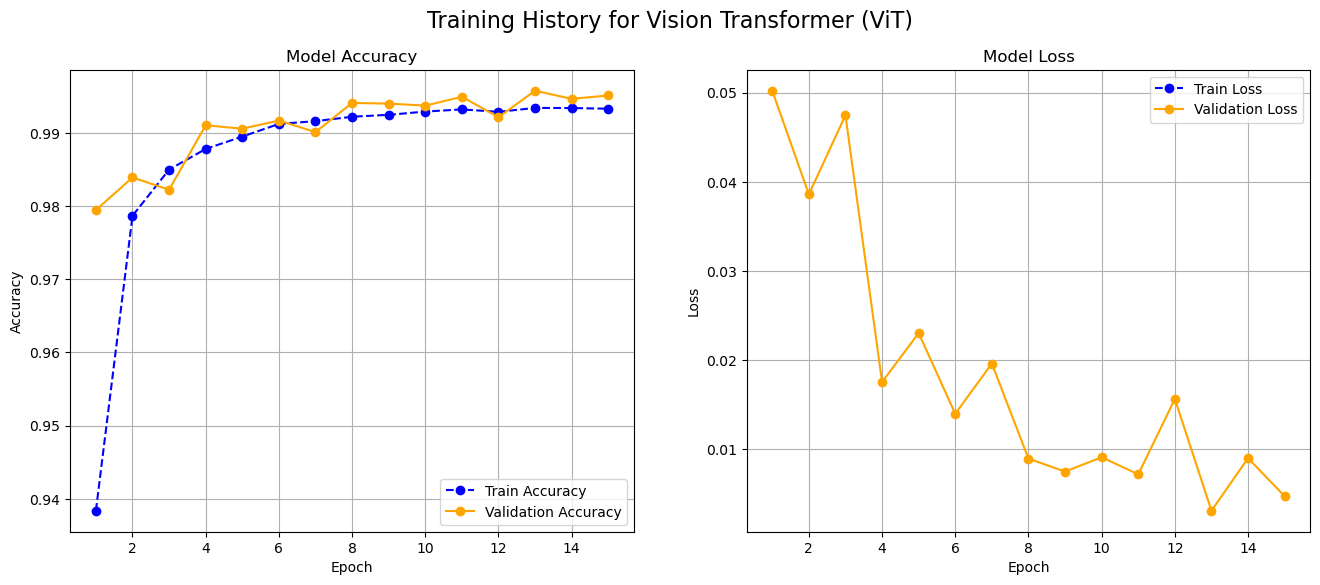


--- Final Evaluation on Test Set for Vision Transformer (ViT) ---


Evaluating: 100%|████████████████████████████████████████████████████████████████████| 290/290 [01:43<00:00,  2.79it/s]


Test Accuracy: 0.8644 | Test Loss: 0.4588


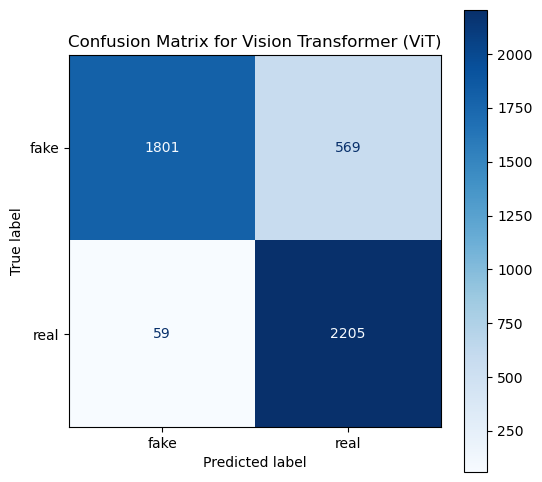

In [15]:
# --- Visualize Results for Model 3 ---
vit_test_acc = plot_results(model_3, vit_history, test_loader, loss_fn_3, device, model_3_name)

In [19]:
# --- Save the trained model's weights ---
torch.save(model_3.state_dict(), 'vit_model.pth')
print("Vision Transformer model saved to vit_model.pth")

Vision Transformer model saved to vit_model.pth


## Final Comparison

After training all three models, we can now directly compare their performance on the unseen test data. A bar chart is a great way to visualize the final test accuracies side-by-side.

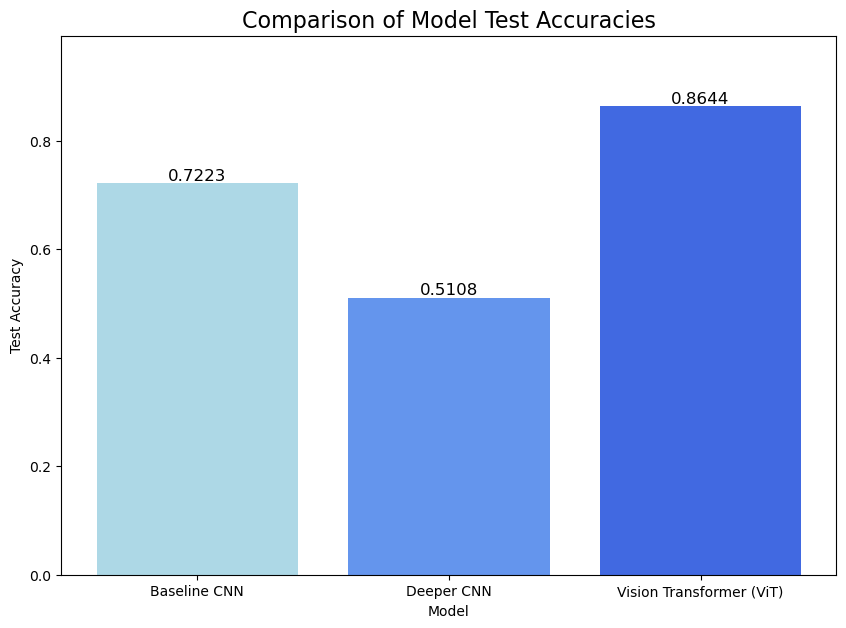

In [16]:
# ==================================================================
# Part 5: Final Model Comparison
# ==================================================================
model_names = [model_1_name, model_2_name, model_3_name]
test_accuracies = [baseline_test_acc, deeper_cnn_test_acc, vit_test_acc]

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(model_names, test_accuracies, color=['lightblue', 'cornflowerblue', 'royalblue'])
ax.set_title('Comparison of Model Test Accuracies', fontsize=16)
ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Model')
ax.set_ylim(0, max(test_accuracies) * 1.15 if test_accuracies else 1.0)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12) 

plt.show()